# Imports & Data Setup

In [336]:
pip install cvxpy


     ---------------------------------------- 1.0/1.0 MB 33.1 MB/s eta 0:00:00
     ---------------------------------------- 72.0/72.0 kB ? eta 0:00:00
     ---------------------------------------- 355.1/355.1 kB ? eta 0:00:00
     ---------------------------------------- 227.7/227.7 kB ? eta 0:00:00
     ---------------------------------------- 8.4/8.4 MB 48.8 MB/s eta 0:00:00
     ---------------------------------------- 292.9/292.9 kB ? eta 0:00:00
     ---------------------------------------- 85.1/85.1 kB 4.7 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import wrds
import scipy.stats as st
import statsmodels.api as sm
import zipfile
import math
import cvxpy as cp

User Input Parameters

In [2]:
#WRDS Account
wrdsUser = ''

#File outputs location
outputFolder = ''


Global Variables

In [3]:
#Time period
minYear = 1974
maxYear = 2024

#Exchange Codes (1: NYSE, 2: American Stock Exchange, 3: NASDAQ)
exchangeCodes = (1, 2, 3)

#Share Codes (common stock share codes are 10 or 11 or 12)
shareCodes = (10, 11, 12)

nUniverseOfFirms = 1000

Download Data

In [ ]:
#DO NOT run if you have the csv file already
db = wrds.Connection(wrds_user=wrdsUser)

#Download daily returns (crspq)
# permno = permanent identification number
# date = date of record
# ret = holding period return
# ticker = ticker
# prc = price
# shrout = number of shares outstanding

dcrspRaw = db.raw_sql("""
                      select a.permno, a.date, a.ret, b.ticker, a.prc, a.shrout
                      from crspq.dsf as a
                      left join crspq.dsenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/"""+str(minYear)+"""' and '12/31/"""+str(maxYear)+"""'
                      and b.shrcd in """ + str(shareCodes) + """
                      and b.exchcd in """ + str(exchangeCodes) + """
                      """)
db.close()
dcrspRaw.head()


In [44]:
#CSV download contains all columns in CRSP from 01/01/1974 to 12/30/2022
dcrspRaw = pd.read_csv(outputFolder + 'daily_crsp_raw.zip',compression='zip',usecols=['PERMNO','date','PRC','RET','VOL','SHROUT','SHRCD','EXCHCD'])

C:\Users\lpate\AppData\Local\Temp\ipykernel_22720\3817656545.py:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  dcrspRaw = pd.read_csv(outputFolder + 'daily_crsp_raw.zip',compression='zip',usecols=['PERMNO','date','PRC','RET','VOL','SHROUT','SHRCD','EXCHCD'])


In [45]:
#Clean Daily returns table (dcrspRaw) and download to file

dcrspRaw['date'] = pd.to_datetime(dcrspRaw['date'], format='%Y-%m-%d')
dcrspRaw['PERMNO'] = dcrspRaw['PERMNO'].astype(int)
dcrspRaw['PRC']=pd.to_numeric(dcrspRaw['PRC'], errors='coerce')
dcrspRaw['SHROUT']=pd.to_numeric(dcrspRaw['SHROUT'], errors='coerce')
dcrspRaw['RET']=pd.to_numeric(dcrspRaw['RET'], errors='coerce')
dcrspRaw['VOL']=pd.to_numeric(dcrspRaw['VOL'], errors='coerce')
dcrspRaw['SHRCD']=pd.to_numeric(dcrspRaw['SHRCD'], errors='coerce')
dcrspRaw['EXCHCD']=pd.to_numeric(dcrspRaw['EXCHCD'], errors='coerce')

dcrspRaw.dropna(axis=0, inplace=True)
dcrspRaw.sort_values(by=['PERMNO', 'date'], ascending=False, inplace=True)
dcrspRaw.reset_index(drop=True, inplace=True)

dcrspRaw['year']=dcrspRaw['date'].dt.year
dcrspRaw['quarter']=dcrspRaw['date'].dt.quarter
dcrspRaw['marketCap']=dcrspRaw['PRC'].abs() * dcrspRaw['SHROUT']

dcrspRaw.to_pickle(outputFolder + 'daily_returns.pkl')


In [ ]:
#DO NOT run if you have the csv file already
db = wrds.Connection(wrds_user=wrdsUser)

#Download annual data from Compustat
# gvkey = Global Company Key
# tic = Ticker Symbol
# fyear = Data Year - Fiscal
# dvpsx_f = Dividends per Share - Ex-Date - Fiscal
# prcc_f = Price Close - Annual - Fiscal

compustatRaw = conn.raw_sql("""
                            select gvkey, tic, fyear, dvpsx_f, PRCC_F, DVC
                            from comp.funda
                            where fyear >= """ + str(minYear) + """
                            """)

compustatRaw['fyear'] = compustatRaw['fyear'].astype(int)
compustatRaw = compustatRaw.rename(columns={'fyear':'year'})
compustatRaw = compustatRaw.sort_values(by = ['gvkey','year']).drop_duplicates()

linkData = conn.raw_sql('''
                            select gvkey, lpermno
                            from crsp.Ccmxpf_linktable
                            ''')
linkData = linkData.rename(columns={'lpermno':'permno'}).dropna().drop_duplicates()
linkData['permno'] = linking_data['permno'].astype(int)

db.close()

compustatRaw = pd.merge(left=compustatRaw, right=linkData, on=['gvkey'], how='left')
compustatRaw
compustatRaw.to_pickle(outputFolder + 'compustatRaw.pkl')


In [22]:
#CSV download contains all columns in Compustat from 01/01/1974 to 12/30/2022
compustatRaw = pd.read_csv(outputFolder + 'daily_compustat_raw.zip',compression='zip',usecols=['gvkey','tic','fyear','prcc_f','dvpsx_f'])
compustatRaw.to_pickle(outputFolder + 'compustatRaw.pkl')

In [29]:
#CSV download contains linking table to link CRSP permno to Compustat gvkey
linkTable = pd.read_csv(outputFolder + 'linking_table.zip', compression='zip')
linkTable = linkTable.dropna()
linkTable = linkTable.rename(columns={'LPERMNO':'PERMNO'})
linkTable.to_pickle(outputFolder + 'linkTable.pkl')

Load Data

In [197]:
dcrspRaw = pd.read_pickle(outputFolder + 'daily_returns.pkl')

In [ ]:
compustatRaw = pd.read_pickle(outputFolder + 'compustatRaw.pkl')

In [19]:
linkTable = pd.read_pickle(outputFolder + 'linkTable.pkl')

# Find universe of firms
Our universe stock criteria
- Have traded for at least 200 trading days of the year
- Share codes are 10 or 11
- Are trading on the last trading day of the year
- Have market cap in top 1000 of stocks on last trading day of year

In [198]:
dailyReturns = dcrspRaw.copy()

In [5]:
#dailyReturns = dailyReturns[(dailyReturns['VOL'] != 0) | (dailyReturns['RET'] != 0)]

In [199]:
#Count number of trading days and remove rows with less than 200
dailyReturns['nTradingDays'] = dailyReturns.groupby(['PERMNO','year'])['RET'].transform('count')
dailyReturns = dailyReturns[dailyReturns['nTradingDays']>200]
dailyReturns
dailyReturns = dailyReturns.drop(columns=['nTradingDays'])

In [200]:
#Remove rows where SHRCD is not 10 or 11
dailyReturns = dailyReturns[(dailyReturns['SHRCD'] == 11.0) | (dailyReturns['SHRCD'] == 10.0)]

#Remove rows where EXCHCD is not 1, 2, or 3
dailyReturns = dailyReturns[(dailyReturns['EXCHCD'] == 1.0) | (dailyReturns['EXCHCD'] == 2.0) | (dailyReturns['EXCHCD'] == 3.0)]

In [223]:
#Find last trading day of every year in the dataset and get firms trading at that date
lastDate = dailyReturns.groupby(['year'])['date'].max()
yearReturns = dailyReturns.copy()
yearReturns = yearReturns[yearReturns['date'].isin(lastDate.values)]
yearReturns = yearReturns.sort_values(by = ['date','PERMNO']).reset_index(drop=True)
yearReturns

,PERMNO,date,SHRCD,EXCHCD,PRC,VOL,RET,SHROUT,year,quarter,marketCap
0,10006,1974-12-31,10.0,1.0,33.000,3800.0,0.031250,5628.0,1974,4,1.857240e+05
1,10014,1974-12-31,10.0,1.0,1.125,7900.0,0.125000,5077.0,1974,4,5.711625e+03
2,10057,1974-12-31,11.0,1.0,7.375,6500.0,0.017241,4410.0,1974,4,3.252375e+04
3,10102,1974-12-31,10.0,1.0,10.375,8600.0,0.012195,11283.0,1974,4,1.170611e+05
4,10137,1974-12-31,11.0,1.0,12.750,62500.0,0.051546,27292.0,1974,4,3.479730e+05
...,...,...,...,...,...,...,...,...,...,...,...
211629,93397,2022-12-30,11.0,3.0,12.210,54361.0,-0.020335,17684.0,2022,4,2.159216e+05
211630,93423,2022-12-30,11.0,1.0,23.250,1096228.0,0.007366,83157.0,2022,4,1.933400e+06
211631,93426,2022-12-30,11.0,1.0,38.650,41864.0,-0.016539,12551.0,2022,4,4.850961e+05
211632,93434,2022-12-30,11.0,3.0,1.490,91509.0,-0.019737,42623.0,2022,4,6.350827e+04


In [224]:
#Rank firms by market capitalization on last trading of every year
yearReturns['marketCapRank'] = yearReturns.groupby(['year'])['marketCap'].rank(ascending=False, method='first')

#Drop firms whose rank is less than nUniverseOfFirms
yearReturns.drop(yearReturns.loc[yearReturns['marketCapRank'] > nUniverseOfFirms].index, inplace=True)

yearReturns = yearReturns.sort_values(by=['date','marketCapRank']).reset_index(drop=True)

,PERMNO,date,SHRCD,EXCHCD,PRC,VOL,RET,SHROUT,year,quarter,marketCap,marketCapRank
0,10401,1974-12-31,11.0,1.0,44.625,114200.0,0.014205,559757.0,1974,4,2.497916e+07,1.0
1,12490,1974-12-31,11.0,1.0,168.000,48900.0,0.022831,145214.0,1974,4,2.439595e+07,2.0
2,11850,1974-12-31,11.0,1.0,64.625,30500.0,0.023762,223867.0,1974,4,1.446740e+07,3.0
3,11754,1974-12-31,11.0,1.0,62.875,55300.0,0.030738,161545.0,1974,4,1.015714e+07,4.0
4,12079,1974-12-31,11.0,1.0,30.750,173600.0,0.016529,286394.0,1974,4,8.806616e+06,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
48995,53110,2022-12-30,11.0,1.0,109.030,70549.0,-0.014908,29269.0,2022,4,3.191199e+06,996.0
48996,14273,2022-12-30,11.0,1.0,25.270,660557.0,-0.010184,125477.0,2022,4,3.170804e+06,997.0
48997,15795,2022-12-30,11.0,3.0,27.860,386411.0,0.010885,113420.0,2022,4,3.159881e+06,998.0
48998,20347,2022-12-30,11.0,3.0,24.670,1337955.0,0.008585,128005.0,2022,4,3.157883e+06,999.0


In [10]:
#Merge to find universe of firms
dailyReturnsUniverse = pd.merge(dailyReturns, yearReturns[['PERMNO','year']], how='inner', on=['year','PERMNO'])
dailyReturnsUniverse = dailyReturnsUniverse.sort_values(['date','PERMNO']).reset_index(drop=True)
dailyReturnsUniverse
dailyReturnsUniverse.to_pickle(outputFolder + 'dailyReturnsUniverse.pkl')

In [4]:
#Load daily returns universe file
dailyReturnsUniverse = pd.read_pickle(outputFolder + 'dailyReturnsUniverse.pkl')

# Annualize Returns

In [18]:
#Given a dataframe, create a new column with annualized returns. The df will have PERMNO, RET, and year as columns
def annualizeReturns(df):
    df[['ret_plus_one']] = df[['RET']]+1
    df['RET_ANN'] = df.groupby(['PERMNO', 'year'])['ret_plus_one'].cumprod() - 1
    df = df.groupby(['PERMNO','year']).last().reset_index()
    df = df.drop(['ret_plus_one'], axis=1)
    df = df.sort_values(['year', 'PERMNO']).reset_index(drop=True)
    return df



In [25]:
#Annualize returns and output to file
dfAnnualReturnsUniverse = annualizeReturns(dailyReturnsUniverse)
dfAnnualReturnsUniverse.to_pickle(outputFolder + 'annualReturnsUniverse.pkl')
dfAnnualReturnsUniverse


,PERMNO,year,date,SHRCD,PRC,VOL,RET,SHROUT,quarter,marketCap,RET_ANN
0,10006,1974,1974-12-31,10.0,33.000,3800.0,0.031250,5628.0,4,1.857240e+05,-0.393634
1,10014,1974,1974-12-31,10.0,1.125,7900.0,0.125000,5077.0,4,5.711625e+03,-0.400000
2,10057,1974,1974-12-31,11.0,7.375,6500.0,0.017241,4410.0,4,3.252375e+04,-0.354798
3,10102,1974,1974-12-31,10.0,10.375,8600.0,0.012195,11283.0,4,1.170611e+05,-0.177711
4,10137,1974,1974-12-31,11.0,12.750,62500.0,0.051546,27292.0,4,3.479730e+05,-0.298008
...,...,...,...,...,...,...,...,...,...,...,...
141451,93397,2022,2022-12-30,11.0,12.210,54361.0,-0.020335,17684.0,4,2.159216e+05,-0.167307
141452,93423,2022,2022-12-30,11.0,23.250,1096228.0,0.007366,83157.0,4,1.933400e+06,-0.453966
141453,93426,2022,2022-12-30,11.0,38.650,41864.0,-0.016539,12551.0,4,4.850961e+05,0.041218
141454,93429,2022,2022-12-30,11.0,125.470,351597.0,-0.013446,106082.0,4,1.331011e+07,-0.021818


In [26]:
#Annualize returns after Jan 10 and output to file
dailyReturnsUniverse['dayOfYear'] = dailyReturnsUniverse['date'].dt.dayofyear
dailyReturnsUniverseAfterJan10 = dailyReturnsUniverse[dailyReturnsUniverse['dayOfYear'] > 10].copy()
dfAnnualReturnsUniverseAfterJan10 = annualizeReturns(dailyReturnsUniverseAfterJan10)
dfAnnualReturnsUniverseAfterJan10.to_pickle(outputFolder + 'annualReturnsUniverseAfterJan10.pkl')
dfAnnualReturnsUniverseAfterJan10

,PERMNO,year,date,SHRCD,PRC,VOL,RET,SHROUT,quarter,marketCap,RET_ANN,dayOfYear
0,10006,1974,1974-12-31,10.0,33.000,3800.0,0.031250,5628.0,4,1.857240e+05,-0.339417,365
1,10014,1974,1974-12-31,10.0,1.125,7900.0,0.125000,5077.0,4,5.711625e+03,-0.400001,365
2,10057,1974,1974-12-31,11.0,7.375,6500.0,0.017241,4410.0,4,3.252375e+04,-0.379613,365
3,10102,1974,1974-12-31,10.0,10.375,8600.0,0.012195,11283.0,4,1.170611e+05,-0.192662,365
4,10137,1974,1974-12-31,11.0,12.750,62500.0,0.051546,27292.0,4,3.479730e+05,-0.310928,365
...,...,...,...,...,...,...,...,...,...,...,...,...
141451,93397,2022,2022-12-30,11.0,12.210,54361.0,-0.020335,17684.0,4,2.159216e+05,-0.218373,364
141452,93423,2022,2022-12-30,11.0,23.250,1096228.0,0.007366,83157.0,4,1.933400e+06,-0.456009,364
141453,93426,2022,2022-12-30,11.0,38.650,41864.0,-0.016539,12551.0,4,4.850961e+05,0.121264,364
141454,93429,2022,2022-12-30,11.0,125.470,351597.0,-0.013446,106082.0,4,1.331011e+07,0.039822,364


In [4]:
#Load annual daily returns universe file
dfAnnualReturnsUniverse = pd.read_pickle(outputFolder + 'annualReturnsUniverse.pkl')

In [62]:
#Inputs to the function are annualized return array (ret_ann) and signal array
#Function will run regression with annualized return as dependent variable and signal as independent variable
def run_regression(dependent_var, signal):
    return sm.OLS(dependent_var, sm.add_constant(signal)).fit()



# Signal Research Helper Functions

In [16]:
#Function to count how many rows have NaN. Input is a dataframe and array of columns (ex. ['column1', 'column2'])
def count_nan(df, columns):
    
    for column in columns:
        print("Number of rows in column: " + column + " with NaN = ", len(df[df[column].isna()]))
        
    return


#Function to count how many rows have NaN per permno. Input is a dataframe and array of columns (ex. ['column1', 'column2'])
def count_nan_per_permno(df, columns):
    
    result = df.groupby(['PERMNO'])[columns].apply(lambda x: x.isna().sum()).reset_index()
    
    #result.columns = ['PERMNO', 'year'] + [f'{col}_nan_count' for col in columns]
        
    return result

def count_zeros(df, columns):
    for column in columns:
        print("Number of rows in column: " + column + " with zeros = ", len(df[(df[column]==0) | (df[column]==0.0) | (df[column]==0.00)]))
        
    return


In [17]:
#Function that will combine rank columns based on weights
#Inputs: df containing PERMNO and rank columns, array of rank columns, array of lambdas
#Output: a new df with new column called weighted_signal

#IMPORTANT: The number of rank columns and the number of lambdas MUST match. The array of lambdas MUST sum to 1. 

#SUPER IMPORTANT: ORDER MATTERS!! Each element in the rank column array must correspond to the same element in the lambda array

#Example: If rank=['marketCapRank', 'std_dev_rank'] and lambdas=[0.3, 0.7], that means 0.3 corresponds to marketCapRank

def create_weighted_signal(df, rank_cols, lambdas):
    
    if len(lambdas) != len(rank_cols):
        raise ValueError("The number of lambdas must match the number of rank columns.")
    
    if abs(sum(lambdas) - 1) > 1e-10:
        raise ValueError("Lambdas must add up to 1.")
    
    #Calculated weighted signal
    df_weighted_signal = df[rank_cols].multiply(lambdas).sum(axis=1)
    
    #Merge weighted signal back into df
    df_new = df.copy()
    df_new['weighted_signal'] = df_weighted_signal
    
    return df_new

In [18]:
#Function that returns portfolio weights based on dataframe containing weighted signal column
#Inputs are type of portfolio weighting and dataframe containing rank columns, weighted signal column, permnos
#weight_type options are: 
#   1. equal: all stocks are weighted equally 
#   2. value: stocks weighted based on market cap
#   3. signal: stocks weighted based on weighted signal column

def calc_portfolio_weights(df, weight_type):
    if weight_type == 'equal':
        
        counts = df.groupby('year')['PERMNO'].transform('nunique')
        df['count'] = counts
        df['p_weight'] = 1/df['count']
        return df
    
    elif weight_type == 'value':
        
        #Calculate the total market cap for each year
        mcap_sum = df.groupby('year')['marketCap'].sum()
        
        # Calculate the weight of each market cap within its respective year
        df['p_weight'] = df.apply(lambda row: row['marketCap'] / mcap_sum[row['year']], axis=1)
        return df
    
    elif weight_type == 'signal':
        
        #Calculate the total weighted signal for each year
        wsignal_sum = df.groupby('year')['weighted_signal'].sum()
        
        # Calculate the weight of each signal within its respective year
        #df['p_weight'] = df.apply(lambda row: 1-(row['weighted_signal'] / wsignal_sum[row['year']]), axis=1)
        df['p_weight'] = df.apply(lambda row: row['weighted_signal'] / wsignal_sum[row['year']], axis=1)
        return df

In [19]:
#The df in the input must have 'RET' for return and 'L_p_weight' for lagged portfolio return as columns
def calc_portfolio_returns(df):
    
    df['p_ret'] = df['RET']*df['L_p_weight']
    
    daily_p_ret = df.groupby('date')['p_ret'].sum().reset_index()
    
    return daily_p_ret

def calc_portfolio_stats(df):
    df['year'] = df['date'].dt.year
    
    #Calculate average rate of return and plot
    avg_return = df.groupby('year')['p_ret'].mean().reset_index(name='Avg Return')
    df.groupby('year')['p_ret'].mean().plot()
    plt.xlabel('Year')
    plt.ylabel('Average Portfolio Return')
    plt.show()
    
    #Calculate compound rate of return
    df[['p_ret_plus_one']] = df[['p_ret']]+1
    df['cumprod'] = df.groupby(['year'])['p_ret_plus_one'].cumprod()-1
    df_last_date = df.groupby(['year'])['date'].last().reset_index()
    df_compound = pd.merge(left=df_last_date, right=df, on=['year', 'date'], how='left')
    df_compound = df_compound.rename(columns={'cumprod':'Compound Return'})
    
    #Calculate standard deviation of portfolio returns
    std_returns = df.groupby('year')['p_ret'].std().reset_index(name='Std Dev')
    df.groupby('year')['p_ret'].std().plot()
    plt.xlabel('Year')
    plt.ylabel('Standard Deviation of Returns')
    plt.show()
    
    #Put everything in one df
    df_new = pd.merge(df_compound, avg_return, on='year', how='left')
    df_new = df_new.merge(std_returns, on='year')
    df_new['ann_std'] = df_new['Std Dev']*math.sqrt(252)
    
    return df_new

In [9]:
#Function to calculate beta
def beta(ret, rm):
    return np.cov(ret, rm)[0,1]/np.var(rm)

# Financial Ratios Data Cleanup

In [51]:
#Financial ratios data from 1/1/1974 to 12/31/2022 with the following columns:

# divyield = Dividend yield
# curr_ratio = Current ratio
# de_ratio = Total debt/Equity
# bm = Book/Market
# pe_exi = Price-to-Earnings, excluding Extraordinary Items (diluted)

fin_ratio_raw = pd.read_csv(outputFolder + 'fin_ratios_raw.zip',compression='zip')

#Check how many rows have date as NaN
count_nan(fin_ratio_raw, ['adate', 'qdate'])

#Drop NaN in any column
fin_ratio_raw.dropna(subset=['divyield', 'curr_ratio', 'de_ratio', 'bm', 'pe_exi', 'adate', 'roe'], inplace=True)

#adate ('as-of date') - fiscal year-end for a company's financial statements
#public_date - date when accounting information is disclosed to market
fin_ratio_raw['formatted_adate'] = pd.to_datetime(fin_ratio_raw['adate'], format='%Y-%m-%d')
fin_ratio_raw['formatted_public_date'] = pd.to_datetime(fin_ratio_raw['public_date'], format='%Y-%m-%d')

#In adate, get the last public_date and merge with raw data
#fin_ratios = pd.merge(fin_ratio_raw.groupby(['permno', 'formatted_adate'])['formatted_public_date'].last().reset_index(), fin_ratio_raw, how='left', on=['permno','formatted_adate','formatted_public_date'])
fin_ratio_raw['public_date_yr'] = fin_ratio_raw['formatted_public_date'].dt.year.astype(int)
last_dates_indices = fin_ratio_raw.groupby(['permno', 'public_date_yr'])['formatted_public_date'].idxmax()
fin_ratios = fin_ratio_raw.loc[last_dates_indices, ['permno', 'formatted_adate', 'formatted_public_date', 'bm', 'pe_exi', 'de_ratio', 'curr_ratio', 'divyield', 'roe']]
#fin_ratios = fin_ratio_raw.groupby(['permno', 'formatted_adate'])['formatted_public_date'].last().reset_index()

fin_ratios['year']=fin_ratios['formatted_public_date'].dt.year.astype(int)

#Rename columns
fin_ratios = fin_ratios.rename(columns={'permno':'PERMNO'})

#Export cleaned financial ratios to folder
fin_ratios.to_pickle(outputFolder + 'fin_ratios.pkl')

Number of rows in column: adate with NaN =  65422
Number of rows in column: qdate with NaN =  125339


# Beta Data Cleanup

In [115]:
#Yearly beta per company from 1974 to 2022 with the following columns

# betav = Beta value

betas_raw = pd.read_csv(outputFolder + 'betas_raw.zip',compression='zip')

#Clean up date and year
betas_raw['formatted_date'] = pd.to_datetime(betas_raw['date'], format='%Y-%m-%d')
betas_raw['betav']=pd.to_numeric(betas_raw['betav'], errors='coerce')
betas_raw['PERMNO']=pd.to_numeric(betas_raw['PERMNO'], errors='coerce')
betas_raw['year']=pd.to_numeric(betas_raw['year'], errors='coerce')

betas_raw = betas_raw.drop_duplicates(subset=['year','PERMNO'], keep='last')

#Export cleaned betas to folder
betas_raw.to_pickle(outputFolder + 'betas.pkl')

# Example Signals

In [201]:
#Get df where year >= 2000
dailyReturnsUniverse = dailyReturnsUniverse[dailyReturnsUniverse['year']>=2000].reset_index()
dailyReturnsUniverse

,index,PERMNO,date,SHRCD,EXCHCD,PRC,VOL,RET,SHROUT,year,quarter,marketCap
0,6568272,10078,2000-01-03,11.0,3.0,76.50000,15270527.0,-0.012107,1561106.0,2000,1,1.194246e+08
1,6568273,10104,2000-01-03,11.0,3.0,118.12500,24831819.0,0.054099,1423672.0,2000,1,1.681713e+08
2,6568274,10107,2000-01-03,11.0,3.0,116.56250,26937123.0,-0.001606,5160025.0,2000,1,6.014654e+08
3,6568275,10108,2000-01-03,11.0,1.0,24.75000,506900.0,0.042105,128237.0,2000,1,3.173866e+06
4,6568276,10137,2000-01-03,11.0,1.0,25.93750,188800.0,-0.037123,110436.0,2000,1,2.864434e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
5783372,12351644,93330,2022-12-30,11.0,1.0,141.82001,78692.0,-0.000352,36898.0,2022,4,5.232875e+06
5783373,12351645,93356,2022-12-30,11.0,3.0,128.42999,136809.0,-0.008492,36042.0,2022,4,4.628874e+06
5783374,12351646,93369,2022-12-30,11.0,3.0,10.95000,2885338.0,0.001830,416511.0,2022,4,4.560795e+06
5783375,12351647,93374,2022-12-30,11.0,1.0,52.34000,392997.0,-0.009463,103542.0,2022,4,5.419388e+06


In [10]:
#Calculate volatility of each stock per year
df_Stock_Std = dailyReturnsUniverse.groupby(['PERMNO', 'year'])['RET'].std().reset_index()
df_Stock_Std = df_Stock_Std.rename(columns={'RET':'STDEV'})
df_Stock_Std['std_dev_rank'] = df_Stock_Std.groupby(['year'])['STDEV'].rank(ascending=True, method='first')

In [16]:
#Calculate last trading day of year
df_Stock_Mc = dailyReturnsUniverse.groupby(['PERMNO','year'])['date'].last().reset_index()

#Merge market cap column
df_Stock_Mc = pd.merge(left=df_Stock_Mc, right=dailyReturnsUniverse[['PERMNO', 'date', 'marketCap']], on=['PERMNO', 'date'], how='left')

#Rank market cap per year
df_Stock_Mc['marketCapRank'] = df_Stock_Mc.groupby(['year'])['marketCap'].rank(ascending=False, method='first')

#Check Apple
df_Stock_Mc[df_Stock_Mc['PERMNO']==14593]

,PERMNO,year,date,marketCap,marketCapRank
1241,14593,2000,2000-12-29,5.136442e+06,415.0
1242,14593,2001,2001-12-31,7.718852e+06,267.0
1243,14593,2002,2002-12-31,5.162483e+06,318.0
1244,14593,2003,2003-12-31,7.880423e+06,278.0
1245,14593,2004,2004-12-31,2.605296e+07,94.0
1246,14593,2005,2005-12-30,6.079141e+07,43.0
1247,14593,2006,2006-12-29,7.298106e+07,39.0
1248,14593,2007,2007-12-31,1.740388e+08,10.0
1249,14593,2008,2008-12-31,7.599692e+07,25.0
1250,14593,2009,2009-12-31,1.909826e+08,4.0


Standard Deviation & Market Cap Signals

In [33]:
#Merge Market cap and Standard deviation datasets and export
dfStock_Mc_Std = pd.merge(left=df_Stock_Mc, right=df_Stock_Std, on=['PERMNO', 'year'], how='inner')
dfStock_Mc_Std.to_pickle(outputFolder + 'stock_mc_std.pkl')

In [12]:
#Get top 20 standard deviation rank
top_std_dev = dfStock_Mc_Std.groupby('year').apply(lambda x: x.nsmallest(20, 'std_dev_rank')).reset_index(drop=True)
top_std_dev

NameError: name 'dfStock_Mc_Std' is not defined

In [35]:
#Get top 20 market cap rank
top_mcap = dfStock_Mc_Std.groupby('year').apply(lambda x: x.nsmallest(20, 'marketCapRank')).reset_index(drop=True)
top_mcap

,PERMNO,year,date,marketCap,marketCapRank,STDEV,std_dev_rank
0,12060,2000,2000-12-29,4.750032e+08,1.0,0.023099,117.0
1,11850,2000,2000-12-29,3.022112e+08,2.0,0.020432,63.0
2,21936,2000,2000-12-29,2.902158e+08,3.0,0.025440,196.0
3,76076,2000,2000-12-29,2.752910e+08,4.0,0.042671,692.0
4,70519,2000,2000-12-29,2.569478e+08,5.0,0.025508,198.0
...,...,...,...,...,...,...,...
455,14541,2022,2022-12-30,3.470689e+08,16.0,0.020736,342.0
456,92611,2022,2022-12-30,3.382684e+08,17.0,0.019502,269.0
457,91233,2022,2022-12-30,3.316659e+08,18.0,0.020421,322.0
458,66181,2022,2022-12-30,3.219201e+08,19.0,0.019731,287.0


In [52]:
#Get intersection of top 20 market cap rank and top 20 standard deviation rank
df_permnos_mcap_stdev = pd.merge(top_std_dev[['PERMNO', 'year', 'std_dev_rank']], top_mcap[['PERMNO', 'year', 'marketCapRank']], on=['year','PERMNO'], how='inner')

In [46]:
#Get top 20 market cap rank and top 20 standard deviation rank
df_permnos_mcap_stdev = pd.concat([top_std_dev, top_mcap], axis=0)

In [47]:
#Create weighted signal column
df_weighted_signal = create_weighted_signal(df_permnos_mcap_stdev, ['std_dev_rank', 'marketCapRank'], [0.5, 0.5])

In [57]:
#Get unique PERMNO per year
df_weighted_signal_unique = df_weighted_signal.drop_duplicates(subset=['year','PERMNO'])

In [59]:
#Rank top 20 in weighted signal
top_weighted_signal = df_weighted_signal_unique.groupby('year').apply(lambda x: x.nsmallest(20, 'weighted_signal')).reset_index(drop=True)

In [70]:
df_p_weights = calc_portfolio_weights(top_weighted_signal, weight_type='signal')

In [71]:
df_p_weights.to_csv(outputFolder + 'df_p_weights.csv', index=False)

In [72]:
df_p_weights = df_p_weights.sort_values(by=['PERMNO', 'year']).reset_index()

#Merge in portfolio weights
df_Daily_Portfolio = pd.merge(left=dailyReturnsUniverse, right=df_p_weights[['PERMNO', 'year', 'p_weight']], on=['PERMNO', 'year'], how='left')
df_Daily_Portfolio = df_Daily_Portfolio.drop(columns=['index'])

In [73]:
df_Daily_Portfolio

,level_0,PERMNO,date,SHRCD,PRC,VOL,RET,SHROUT,year,quarter,marketCap,p_weight
0,0,10078,2000-01-03,11.0,76.50000,15270527.0,-0.012107,1561106.0,2000,1,1.194246e+08,NaN
1,1,10104,2000-01-03,11.0,118.12500,24831819.0,0.054099,1423672.0,2000,1,1.681713e+08,NaN
2,2,10107,2000-01-03,11.0,116.56250,26937123.0,-0.001606,5160025.0,2000,1,6.014654e+08,NaN
3,3,10108,2000-01-03,11.0,24.75000,506900.0,0.042105,128237.0,2000,1,3.173866e+06,NaN
4,4,10137,2000-01-03,11.0,25.93750,188800.0,-0.037123,110436.0,2000,1,2.864434e+06,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5725550,5725550,93356,2022-12-30,11.0,128.42999,136809.0,-0.008492,36042.0,2022,4,4.628874e+06,NaN
5725551,5725551,93369,2022-12-30,11.0,10.95000,2885338.0,0.001830,416511.0,2022,4,4.560795e+06,NaN
5725552,5725552,93374,2022-12-30,11.0,52.34000,392997.0,-0.009463,103542.0,2022,4,5.419388e+06,NaN
5725553,5725553,93429,2022-12-30,11.0,125.47000,351597.0,-0.013446,106082.0,2022,4,1.331011e+07,NaN


In [74]:
#Lag portfolio weights to following year
df_Daily_Portfolio_Lagged = df_Daily_Portfolio.sort_values(by=['PERMNO', 'date'])
df_Daily_Portfolio_Lagged['L_p_weight'] = df_Daily_Portfolio_Lagged.groupby('PERMNO')['p_weight'].shift(252)
df_Daily_Portfolio_Lagged[((df_Daily_Portfolio_Lagged['year']==2000) | (df_Daily_Portfolio_Lagged['year']==2001) | (df_Daily_Portfolio_Lagged['year']==2002)) & (df_Daily_Portfolio_Lagged['PERMNO']==10107)].to_csv(outputFolder + 'msft_lag.csv', index=False)

In [75]:
#If Lagged portfolio weight is NaN, fill with 0
df_Daily_Portfolio_Lagged['L_p_weight'] = df_Daily_Portfolio_Lagged['L_p_weight'].fillna(0)

In [77]:
df_Portfolio_Ret = calc_portfolio_returns(df_Daily_Portfolio_Lagged)

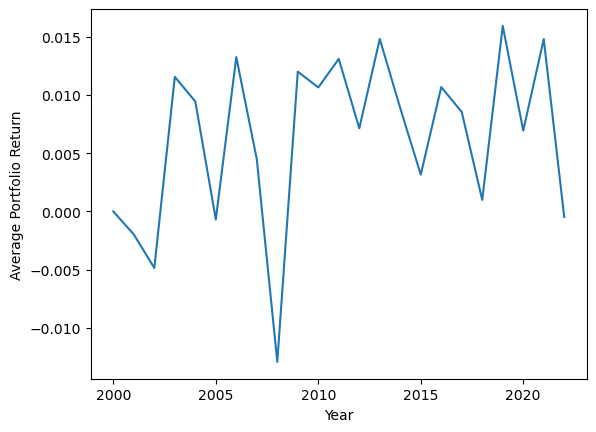

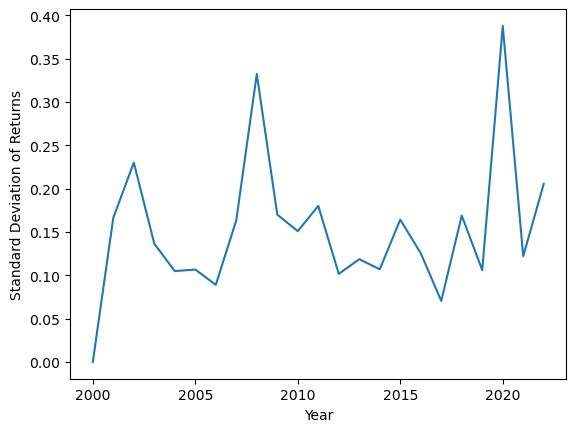

In [78]:
calc_portfolio_stats(df_Portfolio_Ret).to_csv(outputFolder + 'stdev_mcap_stats.csv', index=False)

Volatility Only Signal

In [11]:
top_vol = df_Stock_Std.groupby('year').apply(lambda x: x.nsmallest(20, 'std_dev_rank')).reset_index(drop=True)
top_vol

,PERMNO,year,STDEV,std_dev_rank
0,29022,1974,0.010768,1.0
1,28425,1974,0.010889,2.0
2,14437,1974,0.011169,3.0
3,47431,1974,0.011267,4.0
4,24328,1974,0.011871,5.0
...,...,...,...,...
975,20395,2022,0.013769,16.0
976,47941,2022,0.013798,17.0
977,17750,2022,0.013806,18.0
978,11404,2022,0.013812,19.0


In [67]:
#Export companies with signal to CSV
pd.merge(left=top_vol, right=linkTable[['PERMNO','tic','conm']], on=['PERMNO'], how='left').to_csv(outputFolder + 'top_vol_rank.csv', index=False)

In [68]:
top_vol.to_csv(outputFolder + 'top_vol_rank.csv', index=False)

In [12]:
#Merge with dailyReturnUniverse to get returns data
df_top_vol = pd.merge(left=top_vol, right=dailyReturnsUniverse, on=['PERMNO', 'year'], how='left')
df_top_vol

,PERMNO,year,STDEV,std_dev_rank,date,SHRCD,EXCHCD,PRC,VOL,RET,SHROUT,quarter,marketCap
0,29022,1974,0.010768,1.0,1974-01-02,10.0,2.0,-34.87500,0.0,0.007220,1221.0,1,4.258238e+04
1,29022,1974,0.010768,1.0,1974-01-03,10.0,2.0,-34.87500,0.0,0.000000,1221.0,1,4.258238e+04
2,29022,1974,0.010768,1.0,1974-01-04,10.0,2.0,34.12500,300.0,-0.021505,1221.0,1,4.166662e+04
3,29022,1974,0.010768,1.0,1974-01-07,10.0,2.0,-34.31250,0.0,0.005495,1221.0,1,4.189556e+04
4,29022,1974,0.010768,1.0,1974-01-08,10.0,2.0,-34.25000,0.0,-0.001821,1221.0,1,4.181925e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247787,18163,2022,0.013829,20.0,2022-12-23,11.0,1.0,152.62000,3401860.0,0.002825,2369697.0,4,3.616632e+08
247788,18163,2022,0.013829,20.0,2022-12-27,11.0,1.0,153.95000,4215100.0,0.008714,2369697.0,4,3.648149e+08
247789,18163,2022,0.013829,20.0,2022-12-28,11.0,1.0,151.96001,4197560.0,-0.012926,2369697.0,4,3.600992e+08
247790,18163,2022,0.013829,20.0,2022-12-29,11.0,1.0,152.59000,3809088.0,0.004146,2369697.0,4,3.615921e+08


In [13]:
df_vol_p_weights = calc_portfolio_weights(df_top_vol, 'equal')

In [14]:
#Lag portfolio weights to following year
vol_equal_weights_Lagged = df_vol_p_weights.sort_values(by=['PERMNO', 'date'])
vol_equal_weights_Lagged['L_p_weight'] = vol_equal_weights_Lagged.groupby('PERMNO')['p_weight'].shift(252)

#If Lagged portfolio weight is NaN, fill with 0
vol_equal_weights_Lagged['L_p_weight'] = vol_equal_weights_Lagged['L_p_weight'].fillna(0)

vol_equal_portfolio = calc_portfolio_returns(vol_equal_weights_Lagged)

In [15]:
#Calculate portfolio returns -- equal weighting
vol_equal_portfolio = calc_portfolio_returns(df_vol_p_weights)

KeyError: 'L_p_weight'

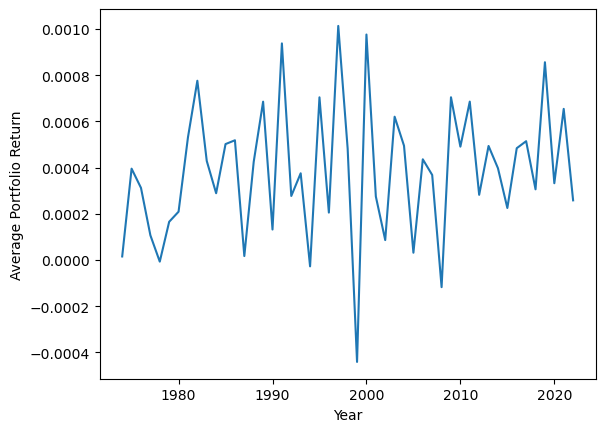

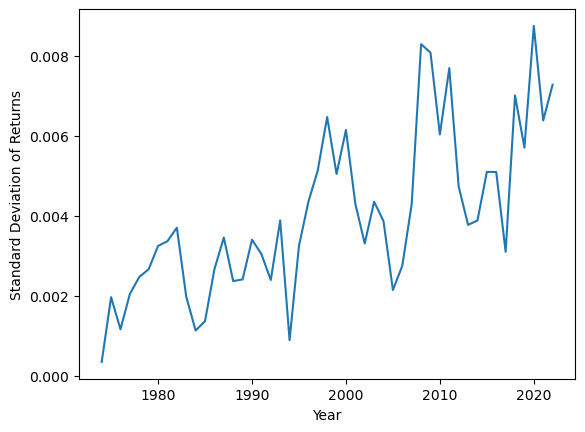

In [17]:
calc_portfolio_stats(vol_equal_portfolio).to_csv(outputFolder + 'vol_only_ouput.csv', index=False)

In [60]:
lastDateVol = df_top_vol.groupby(['year'])['date'].max().reset_index()
df_vol_last = pd.merge(left=lastDateVol, right=df_top_vol, on=['year','date'], how='left')
df_vol_value_p_weights = calc_portfolio_weights(df_vol_last, 'value')
df_vol_value_p_weights = df_vol_value_p_weights.sort_values(by=['PERMNO', 'date'])
df_vol_value_p_weights['L_p_weight'] = df_vol_value_p_weights.groupby('PERMNO')['p_weight'].shift(1)
#df_vol_value_p_weights = pd.merge(left=df_top_vol, right=df_vol_value_p_weights[['year','PERMNO','p_weight','L_p_weight']], on=['year','PERMNO'], how='inner')
df_vol_value_p_weights = pd.merge(left=dailyReturnsUniverse, right=df_vol_value_p_weights[['year','PERMNO','p_weight','L_p_weight']], on=['year','PERMNO'], how='left')
df_vol_value_p_weights['L_p_weight'] = df_vol_value_p_weights['L_p_weight'].fillna(0)

In [31]:
df_vol_value_p_weights[df_vol_value_p_weights['year']==2011].to_csv('testvol.csv', index=False)

In [61]:
#Calculate portfolio returns -- equal weighting
vol_value_portfolio = calc_portfolio_returns(df_vol_value_p_weights)

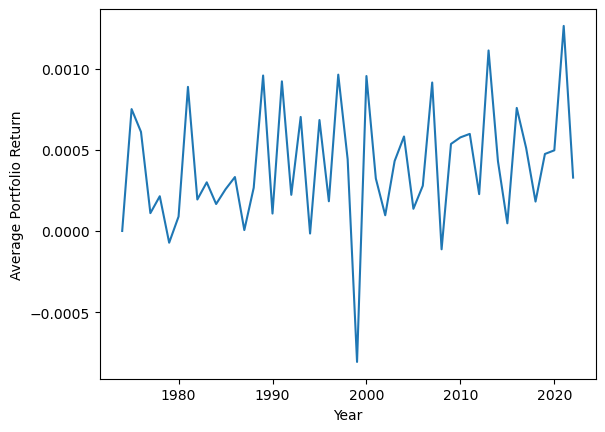

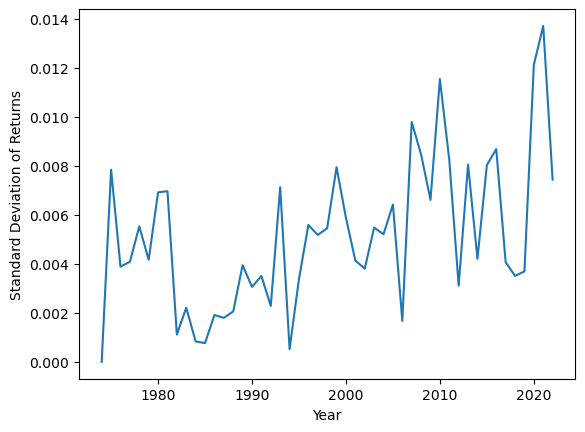

In [62]:
calc_portfolio_stats(vol_value_portfolio).to_csv(outputFolder + 'vol_only_value_ouput.csv', index=False)

# Low Debt/Equity Ratio Signal
Debt/Equity is de_ratio in Compustat Financial Ratios data

In [63]:
#Read in financial ratios and clean data if necessary
fin_ratios = pd.read_pickle(outputFolder + 'fin_ratios.pkl')

In [64]:
tempde = dailyReturnsUniverse.groupby(['year', 'PERMNO']).first().reset_index()
tempde = tempde[['year','PERMNO']]
ratios_with_returns = pd.merge(left=tempde, right=fin_ratios, on=['year','PERMNO'], how='left')

In [65]:
#Create a new rank column that ranks debt/equity ratio every year
ratios_with_returns['de_ratio_rank'] = ratios_with_returns.groupby(['year'])['de_ratio'].rank(ascending=True, method='first')

In [66]:
#Get top 20 ranked for every year
de_ratio_rank = ratios_with_returns.groupby('year').apply(lambda x: x.nsmallest(20, 'de_ratio_rank')).reset_index(drop=True)

In [15]:
#Export companies with signal to CSV
pd.merge(left=de_ratio_rank, right=linkTable[['PERMNO','tic','conm']], on=['PERMNO'], how='left').to_csv(outputFolder + 'de_ratio_rank.csv', index=False)

In [67]:
#Get daily returns of PERMNOs that show signal every year
daily_returns_filtered_de = pd.merge(right=dailyReturnsUniverse, left=de_ratio_rank[['PERMNO', 'year', 'de_ratio_rank']], on=['year', 'PERMNO'], how='left')

In [26]:
count_nan(daily_returns_filtered_de, ['RET'])

Number of rows in column: RET with NaN =  0


In [27]:
#Get PERMNO count per year
print(daily_returns_filtered_de.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      20
1   1975      20
2   1976      20
3   1977      20
4   1978      20
5   1979      20
6   1980      20
7   1981      20
8   1982      20
9   1983      20
10  1984      20
11  1985      20
12  1986      20
13  1987      20
14  1988      20
15  1989      20
16  1990      20
17  1991      20
18  1992      20
19  1993      20
20  1994      20
21  1995      20
22  1996      20
23  1997      20
24  1998      20
25  1999      20
26  2000      20
27  2001      20
28  2002      20
29  2003      20
30  2004      20
31  2005      20
32  2006      20
33  2007      20
34  2008      20
35  2009      20
36  2010      20
37  2011      20
38  2012      20
39  2013      20
40  2014      20
41  2015      20
42  2016      20
43  2017      20
44  2018      20
45  2019      20
46  2020      20
47  2021      20
48  2022      20


Equal Weighting

In [28]:
#Calculate portfolio weights -- equal
de_port_equal = daily_returns_filtered_de.copy()
debt_eq_equal_weights = calc_portfolio_weights(de_port_equal, weight_type='equal')
debt_eq_equal_weights = debt_eq_equal_weights.rename(columns={'p_weight':'L_p_weight'})

In [190]:
#Lag portfolio weights to following year
#debt_eq_equal_weights_Lagged = debt_eq_equal_weights.sort_values(by=['PERMNO', 'date'])
#debt_eq_equal_weights_Lagged['L_p_weight'] = debt_eq_equal_weights_Lagged.groupby('PERMNO')['p_weight'].shift(252)

#If Lagged portfolio weight is NaN, fill with 0
#debt_eq_equal_weights_Lagged['L_p_weight'] = debt_eq_equal_weights_Lagged['L_p_weight'].fillna(0)

In [29]:
#Calculate portfolio returns -- equal weighting
de_equal_portfolio = calc_portfolio_returns(debt_eq_equal_weights)
de_equal_portfolio

,date,p_ret
0,1974-01-02,0.016317
1,1974-01-03,0.013646
2,1974-01-04,0.006226
3,1974-01-07,-0.004958
4,1974-01-08,-0.020610
...,...,...
12354,2022-12-23,0.006228
12355,2022-12-27,-0.001521
12356,2022-12-28,-0.020440
12357,2022-12-29,0.018518


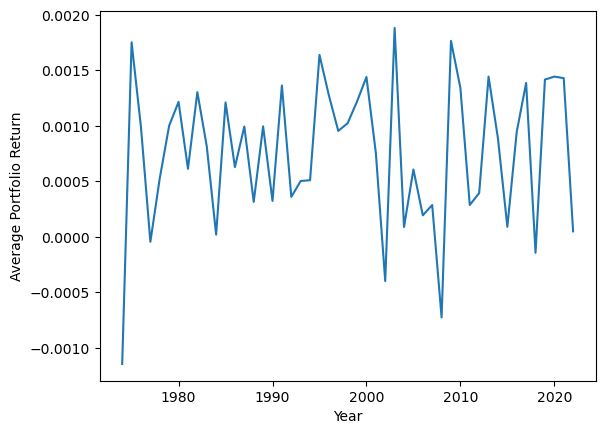

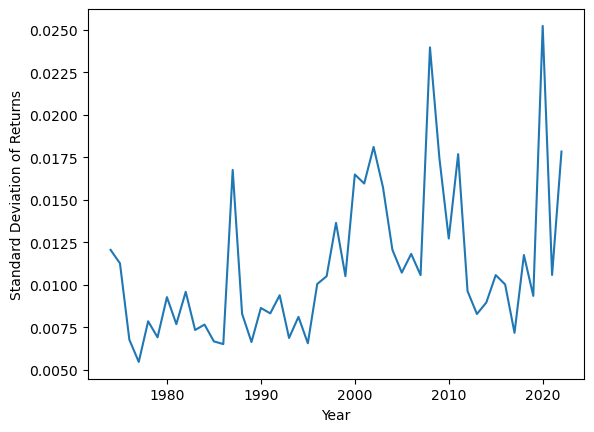

In [30]:
#Return stats on portfolio -- equal weighting
calc_portfolio_stats(de_equal_portfolio).to_csv(outputFolder + 'de_ratio_equal_output.csv', index=False)

Value Weighting

In [68]:
#Calculate portfolio weights -- value
de_port_value = daily_returns_filtered_de.copy()
lastDateDE = de_port_value.groupby(['year'])['date'].max().reset_index()
de_port_last = pd.merge(left=lastDateDE, right=de_port_value, on=['year','date'], how='left')
debt_eq_value_weights = calc_portfolio_weights(de_port_last, weight_type='value')
debt_eq_value_weights = debt_eq_value_weights.sort_values(by=['PERMNO', 'date'])
debt_eq_value_weights['L_p_weight'] = debt_eq_value_weights.groupby('PERMNO')['p_weight'].shift(1)
debt_eq_value_weights = pd.merge(left=dailyReturnsUniverse, right=debt_eq_value_weights[['year','PERMNO','p_weight','L_p_weight']], on=['year','PERMNO'], how='left')
debt_eq_value_weights['L_p_weight'] = debt_eq_value_weights['L_p_weight'].fillna(0)

In [194]:
#Lag portfolio weights to following year
#debt_eq_value_weights_Lagged = debt_eq_value_weights.sort_values(by=['PERMNO', 'date'])
#debt_eq_value_weights_Lagged['L_p_weight'] = debt_eq_value_weights_Lagged.groupby('PERMNO')['p_weight'].shift(252)

#If Lagged portfolio weight is NaN, fill with 0
#debt_eq_value_weights_Lagged['L_p_weight'] = debt_eq_value_weights_Lagged['L_p_weight'].fillna(0)

In [69]:
#Calculate portfolio returns -- value weighting
de_value_portfolio = calc_portfolio_returns(debt_eq_value_weights)
de_value_portfolio

,date,p_ret
0,1974-01-02,0.000000
1,1974-01-03,0.000000
2,1974-01-04,0.000000
3,1974-01-07,0.000000
4,1974-01-08,0.000000
...,...,...
12354,2022-12-23,0.004148
12355,2022-12-27,-0.002500
12356,2022-12-28,-0.013624
12357,2022-12-29,0.015041


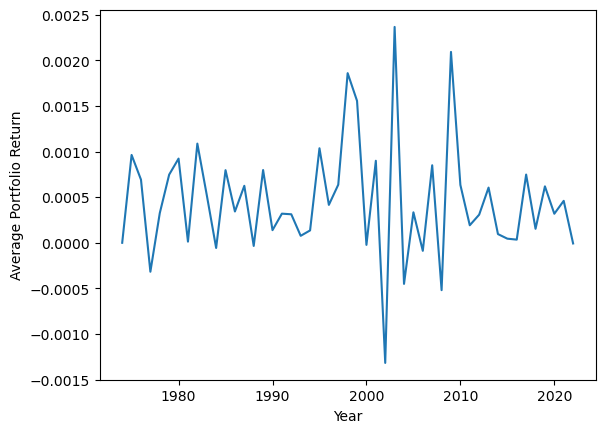

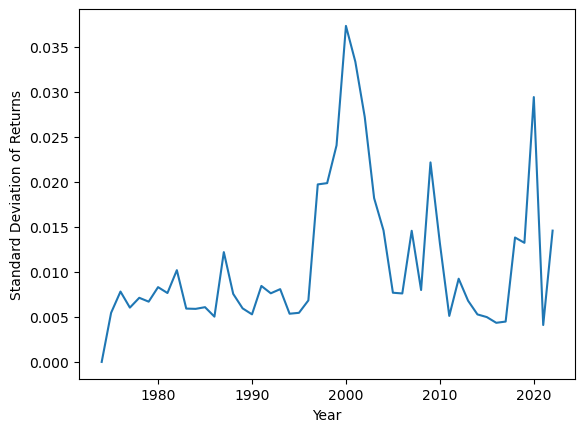

In [71]:
#Return stats on portfolio -- value weighting
calc_portfolio_stats(de_value_portfolio).to_csv(outputFolder + 'de_ratio_value_output.csv', index=False)

# High Dividend Yield Signal
Dividend yield is divyield in Compustat Financial Ratios data

In [46]:
#Read in financial ratios and clean data if necessary
fin_ratios = pd.read_pickle(outputFolder + 'fin_ratios.pkl')

In [47]:
tempdivy = dailyReturnsUniverse.groupby(['year', 'PERMNO']).first().reset_index()
tempdivy = tempdivy[['year','PERMNO']]
ratios_with_returns = pd.merge(left=tempdivy, right=fin_ratios, on=['year','PERMNO'], how='left')

In [48]:
#Create a new rank column that ranks dividend yield every year. Larger value ranked higher
ratios_with_returns['div_yield_rank'] = ratios_with_returns.groupby(['year'])['divyield'].rank(ascending=False, method='first')

In [49]:
#Get top 20 ranked for every year
div_yield_rank = ratios_with_returns.groupby('year').apply(lambda x: x.nsmallest(20, 'div_yield_rank')).reset_index(drop=True)

In [29]:
#Export companies with signal to CSV
pd.merge(left=div_yield_rank, right=linkTable[['PERMNO','tic','conm']], on=['PERMNO'], how='left').to_csv(outputFolder + 'div_yield_rank.csv', index=False)

In [50]:
#Get daily returns of PERMNOs that show signal every year
daily_returns_filtered_div_yield = pd.merge(right=dailyReturnsUniverse, left=div_yield_rank[['PERMNO', 'year', 'div_yield_rank']], on=['year', 'PERMNO'], how='left')

In [58]:
count_nan(daily_returns_filtered_div_yield, ['RET'])

Number of rows in column: RET with NaN =  0


In [59]:
#Get PERMNO count per year
print(daily_returns_filtered_div_yield.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      20
1   1975      20
2   1976      20
3   1977      20
4   1978      20
5   1979      20
6   1980      20
7   1981      20
8   1982      20
9   1983      20
10  1984      20
11  1985      20
12  1986      20
13  1987      20
14  1988      20
15  1989      20
16  1990      20
17  1991      20
18  1992      20
19  1993      20
20  1994      20
21  1995      20
22  1996      20
23  1997      20
24  1998      20
25  1999      20
26  2000      20
27  2001      20
28  2002      20
29  2003      20
30  2004      20
31  2005      20
32  2006      20
33  2007      20
34  2008      20
35  2009      20
36  2010      20
37  2011      20
38  2012      20
39  2013      20
40  2014      20
41  2015      20
42  2016      20
43  2017      20
44  2018      20
45  2019      20
46  2020      20
47  2021      20
48  2022      20


Equal Weighting

In [39]:
#Calculate portfolio weights -- equal
div_yield_equal_temp = daily_returns_filtered_div_yield.copy()
div_yield_equal_weights = calc_portfolio_weights(div_yield_equal_temp, weight_type='equal')
div_yield_equal_weights = div_yield_equal_weights.rename(columns={'p_weight':'L_p_weight'})

In [ ]:
#Lag portfolio weights to following year
#div_yield_equal_weights_Lagged = div_yield_equal_weights.sort_values(by=['PERMNO', 'date'])
#div_yield_equal_weights_Lagged['L_p_weight'] = div_yield_equal_weights_Lagged.groupby('PERMNO')['p_weight'].shift(252)

#If Lagged portfolio weight is NaN, fill with 0
#div_yield_equal_weights_Lagged['L_p_weight'] = div_yield_equal_weights_Lagged['L_p_weight'].fillna(0)

In [40]:
#Calculate portfolio returns -- equal weighting
div_yield_equal_portfolio = calc_portfolio_returns(div_yield_equal_weights)

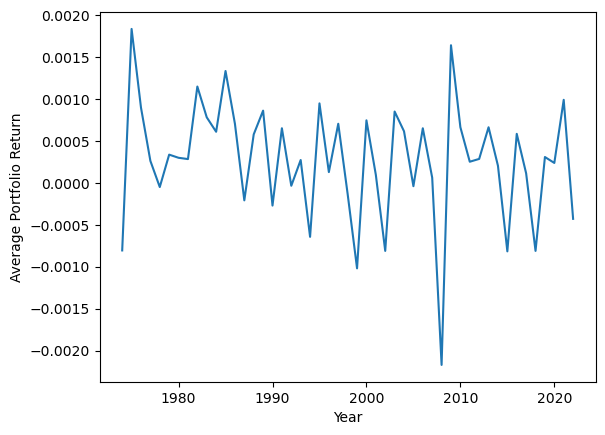

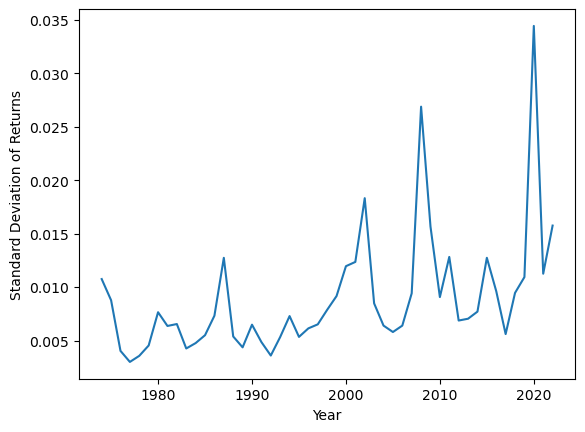

In [41]:
#Return stats on portfolio -- equal weighting
calc_portfolio_stats(div_yield_equal_portfolio).to_csv(outputFolder + 'div_yield_equal_output.csv', index=False)

Value Weighting

In [72]:
#Calculate portfolio weights -- value
div_yield_value_temp = daily_returns_filtered_div_yield.copy()
lastDate_div_yield = div_yield_value_temp.groupby(['year'])['date'].max().reset_index()
div_yield_port_last = pd.merge(left=lastDate_div_yield, right=div_yield_value_temp, on=['year','date'], how='left')
div_yield_value_weights = calc_portfolio_weights(div_yield_port_last, weight_type='value')
div_yield_value_weights = div_yield_value_weights.sort_values(by=['PERMNO', 'date'])
div_yield_value_weights['L_p_weight'] = div_yield_value_weights.groupby('PERMNO')['p_weight'].shift(1)
div_yield_value_weights.to_csv('div_yield_value_weights.csv', index=False)
div_yield_value_weights = pd.merge(left=dailyReturnsUniverse, right=div_yield_value_weights[['year','PERMNO','p_weight','L_p_weight']], on=['year','PERMNO'], how='left')
div_yield_value_weights['L_p_weight'] = div_yield_value_weights['L_p_weight'].fillna(0)

In [73]:
result = div_yield_value_weights.loc[div_yield_value_weights['date'] == '2010-01-12', 'p_weight'].sum()
print(result)

0.9999999999999998


In [ ]:
#Lag portfolio weights to following year
#div_yield_value_weights_Lagged = div_yield_value_weights.sort_values(by=['PERMNO', 'date'])
#div_yield_value_weights_Lagged['L_p_weight'] = div_yield_value_weights_Lagged.groupby('PERMNO')['p_weight'].shift(252)

#If Lagged portfolio weight is NaN, fill with 0
#div_yield_value_weights_Lagged['L_p_weight'] = div_yield_value_weights_Lagged['L_p_weight'].fillna(0)

In [74]:
#Calculate portfolio returns -- value  weighting
div_yield_value_portfolio = calc_portfolio_returns(div_yield_value_weights)

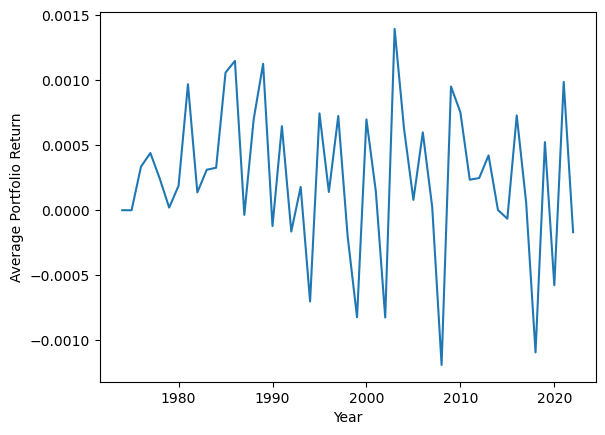

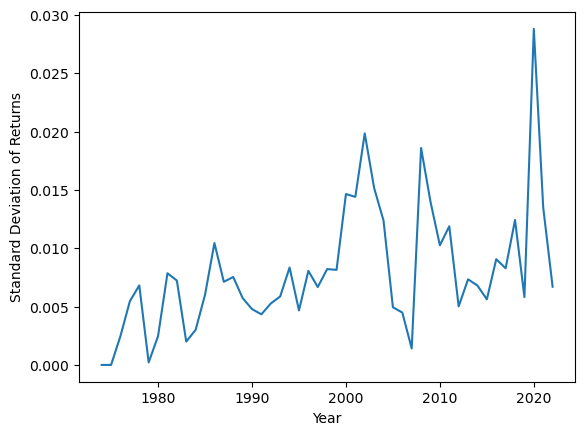

In [75]:
#Return stats on portfolio -- value weighting
calc_portfolio_stats(div_yield_value_portfolio).to_csv(outputFolder + 'div_yield_value_output.csv', index=False)

# High Current Ratio Signal
Current ratio is curr_ratio in Compustat Financial Ratios data

In [76]:
#Read in financial ratios and clean data if necessary
fin_ratios = pd.read_pickle(outputFolder + 'fin_ratios.pkl')

In [77]:
tempcurr = dailyReturnsUniverse.groupby(['year', 'PERMNO']).first().reset_index()
tempcurr = tempcurr[['year','PERMNO']]
ratios_with_returns = pd.merge(left=tempcurr, right=fin_ratios, on=['year','PERMNO'], how='left')

In [78]:
#Create a new rank column that ranks current ratio every year. Larger value ranked higher
ratios_with_returns['curr_ratio_rank'] = ratios_with_returns.groupby(['year'])['curr_ratio'].rank(ascending=False, method='first')

In [79]:
#Get top 20 ranked for every year
curr_ratio_rank = ratios_with_returns.groupby('year').apply(lambda x: x.nsmallest(20, 'curr_ratio_rank')).reset_index(drop=True)

In [43]:
#Export companies with signal to CSV
pd.merge(left=curr_ratio_rank, right=linkTable[['PERMNO','tic','conm']], on=['PERMNO'], how='left').to_csv(outputFolder + 'curr_ratio_rank.csv', index=False)

In [80]:
#Get daily returns of PERMNOs that show signal every year
daily_returns_filtered_curr_ratio = pd.merge(right=dailyReturnsUniverse, left=curr_ratio_rank[['PERMNO', 'year', 'curr_ratio_rank']], on=['year', 'PERMNO'], how='left')

In [73]:
count_nan(daily_returns_filtered_curr_ratio, ['RET'])

Number of rows in column: RET with NaN =  0


In [74]:
#Get PERMNO count per year
print(daily_returns_filtered_curr_ratio.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      20
1   1975      20
2   1976      20
3   1977      20
4   1978      20
5   1979      20
6   1980      20
7   1981      20
8   1982      20
9   1983      20
10  1984      20
11  1985      20
12  1986      20
13  1987      20
14  1988      20
15  1989      20
16  1990      20
17  1991      20
18  1992      20
19  1993      20
20  1994      20
21  1995      20
22  1996      20
23  1997      20
24  1998      20
25  1999      20
26  2000      20
27  2001      20
28  2002      20
29  2003      20
30  2004      20
31  2005      20
32  2006      20
33  2007      20
34  2008      20
35  2009      20
36  2010      20
37  2011      20
38  2012      20
39  2013      20
40  2014      20
41  2015      20
42  2016      20
43  2017      20
44  2018      20
45  2019      20
46  2020      20
47  2021      20
48  2022      20


Equal Weighting

In [81]:
#Calculate portfolio weights -- equal
curr_ratio_equal_temp = daily_returns_filtered_curr_ratio.copy()
curr_ratio_equal_weights = calc_portfolio_weights(curr_ratio_equal_temp, weight_type='equal')
curr_ratio_equal_weights = curr_ratio_equal_weights.rename(columns={'p_weight':'L_p_weight'})

In [ ]:
#Lag portfolio weights to following year
#curr_ratio_equal_weights_Lagged = curr_ratio_equal_weights.sort_values(by=['PERMNO', 'date'])
#curr_ratio_equal_weights_Lagged['L_p_weight'] = curr_ratio_equal_weights_Lagged.groupby('PERMNO')['p_weight'].shift(252)

#If Lagged portfolio weight is NaN, fill with 0
#curr_ratio_equal_weights_Lagged['L_p_weight'] = curr_ratio_equal_weights_Lagged['L_p_weight'].fillna(0)

In [82]:
#Calculate portfolio returns -- equal weighting
curr_ratio_equal_portfolio = calc_portfolio_returns(curr_ratio_equal_weights)

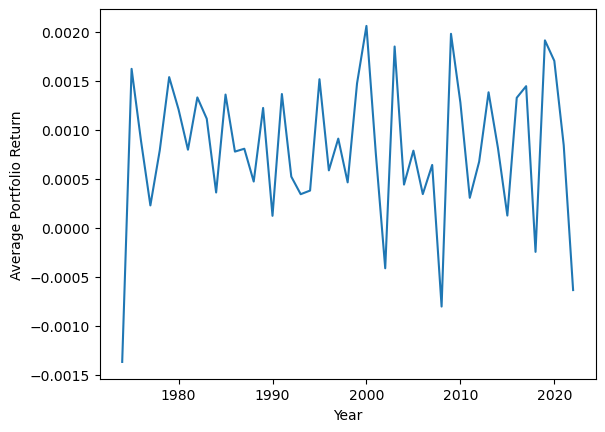

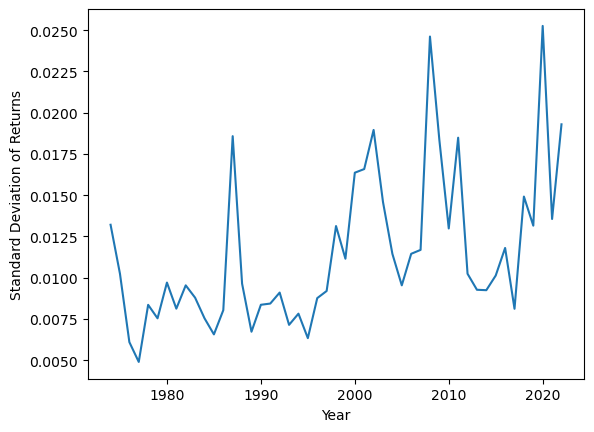

In [83]:
#Return stats on portfolio -- equal weighting
calc_portfolio_stats(curr_ratio_equal_portfolio).to_csv(outputFolder + 'curr_ratio_equal_output.csv', index=False)

Value Weighting

In [84]:
#Calculate portfolio weights -- value
curr_ratio_value_temp = daily_returns_filtered_curr_ratio.copy()
lastDate_curr_ratio = curr_ratio_value_temp.groupby(['year'])['date'].max().reset_index()
curr_ratio_port_last = pd.merge(left=lastDate_curr_ratio, right=curr_ratio_value_temp, on=['year','date'], how='left')
curr_ratio_value_weights = calc_portfolio_weights(curr_ratio_port_last, weight_type='value')
curr_ratio_value_weights = curr_ratio_value_weights.sort_values(by=['PERMNO', 'date'])
curr_ratio_value_weights['L_p_weight'] = curr_ratio_value_weights.groupby('PERMNO')['p_weight'].shift(1)
curr_ratio_value_weights.to_csv('curr_ratio_value_weights.csv', index=False)
curr_ratio_value_weights = pd.merge(left=curr_ratio_value_temp, right=curr_ratio_value_weights[['year','PERMNO','p_weight','L_p_weight']], on=['year','PERMNO'], how='inner')
curr_ratio_value_weights['L_p_weight'] = curr_ratio_value_weights['L_p_weight'].fillna(0)

In [ ]:
#Lag portfolio weights to following year
#curr_ratio_value_weights_Lagged = curr_ratio_value_weights.sort_values(by=['PERMNO', 'date'])
#curr_ratio_value_weights_Lagged['L_p_weight'] = curr_ratio_value_weights_Lagged.groupby('PERMNO')['p_weight'].shift(252)

#If Lagged portfolio weight is NaN, fill with 0
#curr_ratio_value_weights_Lagged['L_p_weight'] = curr_ratio_value_weights_Lagged['L_p_weight'].fillna(0)

In [85]:
#Calculate portfolio returns -- value weighting
curr_ratio_value_portfolio = calc_portfolio_returns(curr_ratio_value_weights)

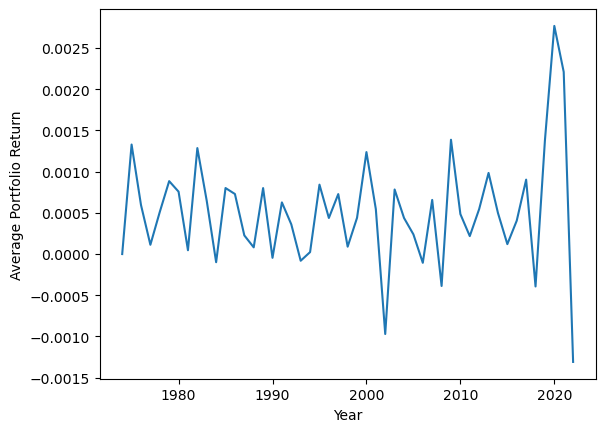

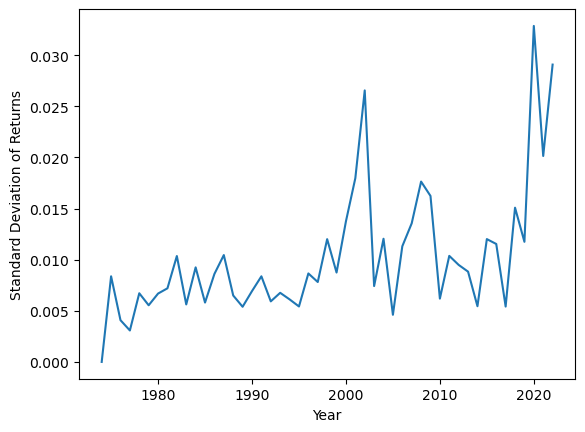

In [86]:
#Return stats on portfolio -- value weighting
calc_portfolio_stats(curr_ratio_value_portfolio).to_csv(outputFolder + 'curr_ratio_value_output.csv', index=False)

# Low Beta Signal
Beta is betav in CRSP

In [10]:
#Load clean betas file
dfBetas = pd.read_pickle(outputFolder + 'betas.pkl')

In [11]:
dfBetasFiltered = dfBetas[dfBetas['betav']>0]

In [12]:
tempbeta = dailyReturnsUniverse.groupby(['year', 'PERMNO']).first().reset_index()
tempbeta = tempbeta[['year','PERMNO']]
betas_with_returns = pd.merge(left=tempbeta, right=dfBetasFiltered, on=['year','PERMNO'], how='left')

In [13]:
#Create a new rank column that ranks beta every year. Smaller value ranked higher
betas_with_returns['betas_rank'] = betas_with_returns.groupby(['year'])['betav'].rank(ascending=True, method='first')

In [91]:
#Get top 20 ranked for every year
betas_rank = betas_with_returns.groupby('year').apply(lambda x: x.nsmallest(20, 'betas_rank')).reset_index(drop=True)

In [58]:
#Export companies with signal to CSV
pd.merge(left=betas_rank, right=linkTable[['PERMNO','tic','conm']], on=['PERMNO'], how='left').to_csv(outputFolder + 'low_betas_rank.csv', index=False)

In [92]:
#Get daily returns of PERMNOs that show signal every year
daily_returns_filtered_betas = pd.merge(right=dailyReturnsUniverse, left=betas_rank[['PERMNO', 'year', 'betas_rank']], on=['year', 'PERMNO'], how='left')

In [85]:
count_nan(daily_returns_filtered_betas, ['RET'])

Number of rows in column: RET with NaN =  0


In [86]:
#Get PERMNO count per year
print(daily_returns_filtered_betas.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      20
1   1975      20
2   1976      20
3   1977      20
4   1978      20
5   1979      20
6   1980      20
7   1981      20
8   1982      20
9   1983      20
10  1984      20
11  1985      20
12  1986      20
13  1987      20
14  1988      20
15  1989      20
16  1990      20
17  1991      20
18  1992      20
19  1993      20
20  1994      20
21  1995      20
22  1996      20
23  1997      20
24  1998      20
25  1999      20
26  2000      20
27  2001      20
28  2002      20
29  2003      20
30  2004      20
31  2005      20
32  2006      20
33  2007      20
34  2008      20
35  2009      20
36  2010      20
37  2011      20
38  2012      20
39  2013      20
40  2014      20
41  2015      20
42  2016      20
43  2017      20
44  2018      20
45  2019      20
46  2020      20
47  2021      20
48  2022      20


Equal Weighting

In [93]:
#Calculate portfolio weights -- equal
betas_equal_temp = daily_returns_filtered_betas.copy()
betas_equal_weights = calc_portfolio_weights(betas_equal_temp, weight_type='equal')
betas_equal_weights = betas_equal_weights.rename(columns={'p_weight':'L_p_weight'})

In [ ]:
#Lag portfolio weights to following year
#betas_equal_weights_Lagged = betas_equal_weights.sort_values(by=['PERMNO', 'date'])
#betas_equal_weights_Lagged['L_p_weight'] = betas_equal_weights_Lagged.groupby('PERMNO')['p_weight'].shift(252)

#If Lagged portfolio weight is NaN, fill with 0
#betas_equal_weights_Lagged['L_p_weight'] = betas_equal_weights_Lagged['L_p_weight'].fillna(0)

In [94]:
#Calculate portfolio returns -- equal weighting
betas_equal_portfolio = calc_portfolio_returns(betas_equal_weights)

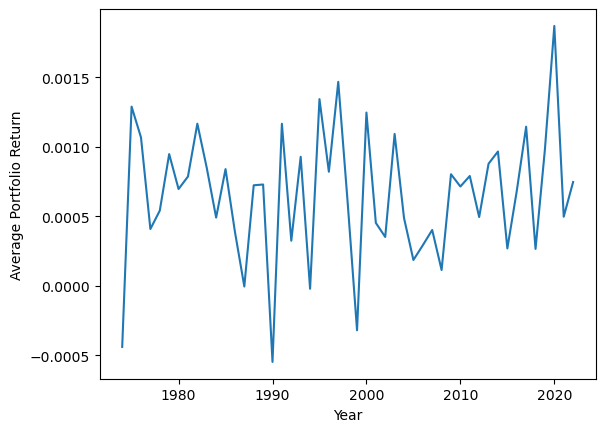

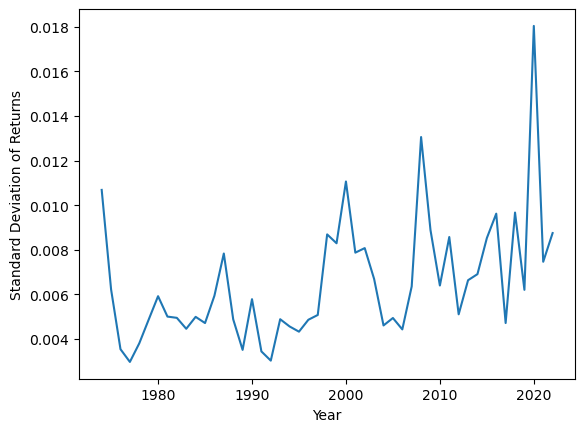

In [95]:
#Return stats on portfolio -- equal weighting
calc_portfolio_stats(betas_equal_portfolio).to_csv(outputFolder + 'low_beta_equal_output.csv', index=False)

Value Weighting

In [96]:
#Calculate portfolio weights -- value
betas_value_temp = daily_returns_filtered_betas.copy()
lastDate_betas = betas_value_temp.groupby(['year'])['date'].max().reset_index()
betas_port_last = pd.merge(left=lastDate_betas, right=betas_value_temp, on=['year','date'], how='left')
betas_value_weights = calc_portfolio_weights(betas_port_last, weight_type='value')
betas_value_weights = betas_value_weights.sort_values(by=['PERMNO', 'date'])
betas_value_weights['L_p_weight'] = betas_value_weights.groupby('PERMNO')['p_weight'].shift(1)
betas_value_weights = pd.merge(left=betas_value_temp, right=betas_value_weights[['year','PERMNO','p_weight','L_p_weight']], on=['year','PERMNO'], how='inner')
betas_value_weights['L_p_weight'] = betas_value_weights['L_p_weight'].fillna(0)

In [ ]:
#Lag portfolio weights to following year
#betas_value_weights_Lagged = betas_value_weights.sort_values(by=['PERMNO', 'date'])
#betas_value_weights_Lagged['L_p_weight'] = betas_value_weights_Lagged.groupby('PERMNO')['p_weight'].shift(252)

#If Lagged portfolio weight is NaN, fill with 0
#betas_value_weights_Lagged['L_p_weight'] = betas_value_weights_Lagged['L_p_weight'].fillna(0)

In [97]:
#Calculate portfolio returns -- value weighting
betas_value_portfolio = calc_portfolio_returns(betas_value_weights)

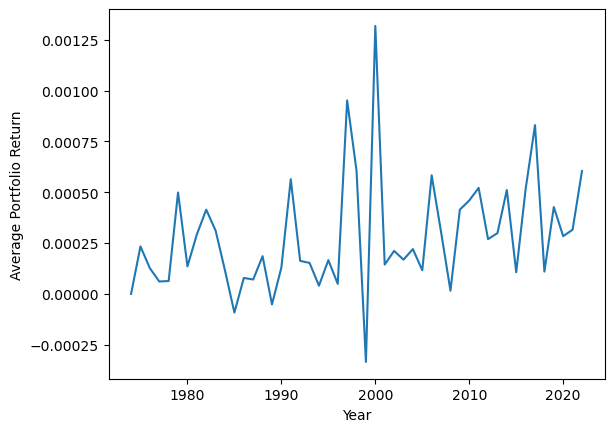

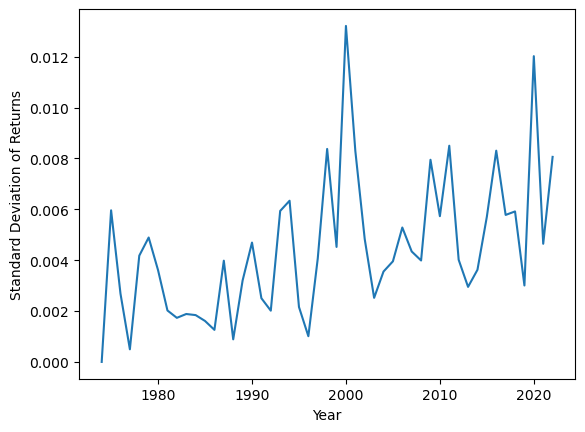

In [98]:
#Return stats on portfolio -- value weighting
calc_portfolio_stats(betas_value_portfolio).to_csv(outputFolder + 'low_beta_value_output.csv', index=False)

# High ROE No Less Than 15%
ROE is roe in Compustat Financial Ratios data

In [99]:
#Read in financial ratios and clean data if necessary
fin_ratios = pd.read_pickle(outputFolder + 'fin_ratios.pkl')

In [100]:
#Filter out ROE less than 0.15
fin_ratios = fin_ratios[fin_ratios['roe'] >= 0.15]

In [101]:
temproe = dailyReturnsUniverse.groupby(['year', 'PERMNO']).first().reset_index()
temproe = temproe[['year','PERMNO']]
ratios_with_returns = pd.merge(left=temproe, right=fin_ratios, on=['year','PERMNO'], how='left')

In [102]:
#Create a new rank column that ranks ROE every year. Larger value ranked higher
ratios_with_returns['roe_rank'] = ratios_with_returns.groupby(['year'])['roe'].rank(ascending=False, method='first')

In [103]:
ratios_with_returns = ratios_with_returns.dropna(subset=['roe', 'roe_rank'])

In [205]:
temp_roe = ratios_with_returns.copy()

In [104]:
#Get top 20 ranked for every year
roe_rank = ratios_with_returns.groupby('year').apply(lambda x: x.nsmallest(20, 'roe_rank')).reset_index(drop=True)

In [68]:
#Export companies with signal to CSV
pd.merge(left=roe_rank, right=linkTable[['PERMNO','tic','conm']], on=['PERMNO'], how='left').to_csv(outputFolder + 'roe_rank.csv', index=False)

In [105]:
#Get daily returns of PERMNOs that show signal every year
daily_returns_filtered_roe = pd.merge(right=dailyReturnsUniverse, left=roe_rank[['PERMNO', 'year', 'roe_rank']], on=['year', 'PERMNO'], how='left')

In [70]:
count_nan(daily_returns_filtered_roe, ['RET'])

Number of rows in column: RET with NaN =  0


In [71]:
#Get PERMNO count per year
print(daily_returns_filtered_roe.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      20
1   1975      20
2   1976      20
3   1977      20
4   1978      20
5   1979      20
6   1980      20
7   1981      20
8   1982      20
9   1983      20
10  1984      20
11  1985      20
12  1986      20
13  1987      20
14  1988      20
15  1989      20
16  1990      20
17  1991      20
18  1992      20
19  1993      20
20  1994      20
21  1995      20
22  1996      20
23  1997      20
24  1998      20
25  1999      20
26  2000      20
27  2001      20
28  2002      20
29  2003      20
30  2004      20
31  2005      20
32  2006      20
33  2007      20
34  2008      20
35  2009      20
36  2010      20
37  2011      20
38  2012      20
39  2013      20
40  2014      20
41  2015      20
42  2016      20
43  2017      20
44  2018      20
45  2019      20
46  2020      20
47  2021      20
48  2022      20


Equal Weighting

In [106]:
#Calculate portfolio weights -- equal
roe_equal_temp = daily_returns_filtered_roe.copy()
roe_equal_weights = calc_portfolio_weights(roe_equal_temp, weight_type='equal')
roe_equal_weights = roe_equal_weights.rename(columns={'p_weight':'L_p_weight'})

In [ ]:
#Lag portfolio weights to following year
#roe_equal_weights_Lagged = roe_equal_weights.sort_values(by=['PERMNO', 'date'])
#roe_equal_weights_Lagged['L_p_weight'] = roe_equal_weights_Lagged.groupby('PERMNO')['p_weight'].shift(252)

#If Lagged portfolio weight is NaN, fill with 0
#roe_equal_weights_Lagged['L_p_weight'] = roe_equal_weights_Lagged['L_p_weight'].fillna(0)

In [107]:
#Calculate portfolio returns -- equal weighting
roe_equal_portfolio = calc_portfolio_returns(roe_equal_weights)

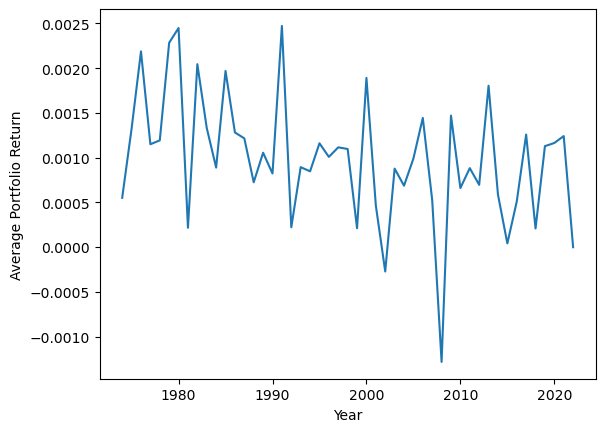

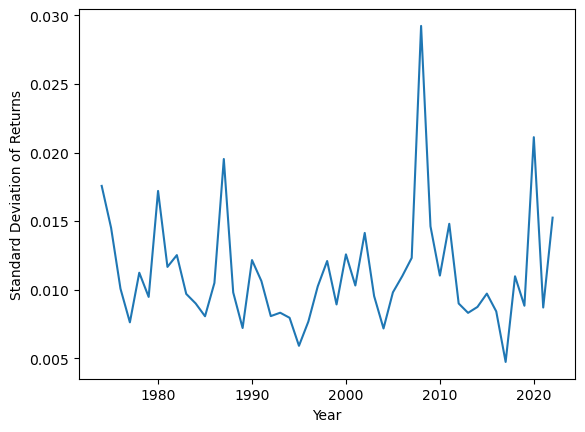

In [108]:
#Return stats on portfolio -- equal weighting
calc_portfolio_stats(roe_equal_portfolio).to_csv(outputFolder + 'roe_equal_output.csv', index=False)

Value Weighting

In [109]:
#Calculate portfolio weights -- value
roe_value_temp = daily_returns_filtered_roe.copy()
lastDate_roe = roe_value_temp.groupby(['year'])['date'].max().reset_index()
roe_port_last = pd.merge(left=lastDate_roe, right=roe_value_temp, on=['year','date'], how='left')
roe_value_weights = calc_portfolio_weights(roe_port_last, weight_type='value')
roe_value_weights = roe_value_weights.sort_values(by=['PERMNO', 'date'])
roe_value_weights['L_p_weight'] = roe_value_weights.groupby('PERMNO')['p_weight'].shift(1)
roe_value_weights = pd.merge(left=roe_value_temp, right=roe_value_weights[['year','PERMNO','p_weight','L_p_weight']], on=['year','PERMNO'], how='inner')
roe_value_weights['L_p_weight'] = roe_value_weights['L_p_weight'].fillna(0)
roe_value_weights

,PERMNO,year,roe_rank,date,SHRCD,EXCHCD,PRC,VOL,RET,SHROUT,quarter,marketCap,p_weight,L_p_weight
0,31800,1974,1.0,1974-01-02,10.0,2.0,11.00000,500.0,0.023256,1697.0,1,1.866700e+04,0.007420,0.00000
1,31800,1974,1.0,1974-01-03,10.0,2.0,11.62500,5100.0,0.056818,1697.0,1,1.972762e+04,0.007420,0.00000
2,31800,1974,1.0,1974-01-04,10.0,2.0,11.62500,4300.0,0.000000,1697.0,1,1.972762e+04,0.007420,0.00000
3,31800,1974,1.0,1974-01-07,10.0,2.0,12.00000,12400.0,0.032258,1697.0,1,2.036400e+04,0.007420,0.00000
4,31800,1974,1.0,1974-01-08,10.0,2.0,11.00000,3100.0,-0.083333,1697.0,1,1.866700e+04,0.007420,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247120,13949,2022,20.0,2022-12-23,11.0,3.0,178.14000,346045.0,0.001800,135391.0,4,2.411855e+07,0.007301,0.01206
247121,13949,2022,20.0,2022-12-27,11.0,3.0,178.99001,561305.0,0.004772,135391.0,4,2.423364e+07,0.007301,0.01206
247122,13949,2022,20.0,2022-12-28,11.0,3.0,175.47000,395551.0,-0.019666,135391.0,4,2.375706e+07,0.007301,0.01206
247123,13949,2022,20.0,2022-12-29,11.0,3.0,179.86000,382056.0,0.025019,135391.0,4,2.435143e+07,0.007301,0.01206


In [ ]:
#Lag portfolio weights to following year
#roe_value_weights_Lagged = roe_value_weights.sort_values(by=['PERMNO', 'date'])
#roe_value_weights_Lagged['L_p_weight'] = roe_value_weights_Lagged.groupby('PERMNO')['p_weight'].shift(252)

#If Lagged portfolio weight is NaN, fill with 0
#roe_value_weights_Lagged['L_p_weight'] = roe_value_weights_Lagged['L_p_weight'].fillna(0)

In [110]:
#Calculate portfolio returns -- value weighting
roe_value_portfolio = calc_portfolio_returns(roe_value_weights)

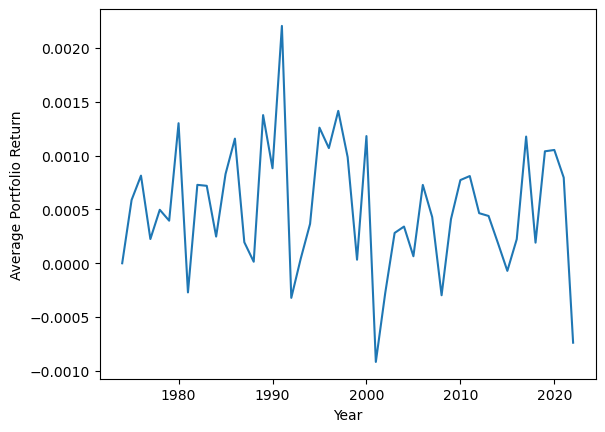

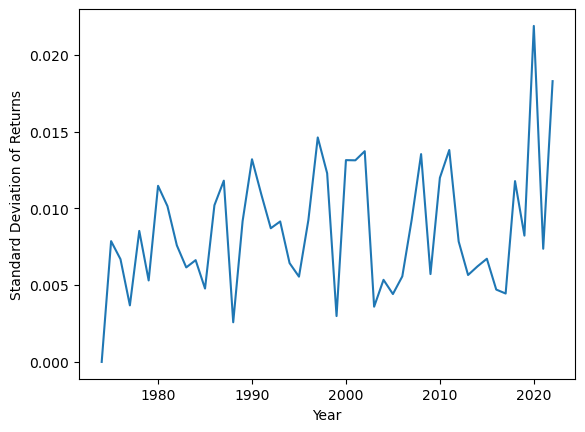

In [111]:
#Return stats on portfolio -- value weighting
calc_portfolio_stats(roe_value_portfolio).to_csv(outputFolder + 'roe_value_output.csv', index=False)

# Low YoY Change in CapEx/PP&E
CapEx (capx) and PP&E (ppent) from Compustat

In [112]:
#CSV download contains all columns in Compustat from 01/01/1973 to 12/30/2022. Bring in only subset of columns
capx_ppe_raw = pd.read_csv(outputFolder + 'daily_compustat_raw_1973.zip',compression='zip',usecols=['gvkey','tic','fyear','capx','ppent'])

In [113]:
#Clean ebit_pi_raw data
capx_ppe_raw.dropna(subset=['fyear','capx','ppent'], inplace=True)
capx_ppe_raw['fyear']=pd.to_numeric(capx_ppe_raw['fyear'], errors='coerce', downcast='integer')
capx_ppe_raw['capx']=pd.to_numeric(capx_ppe_raw['capx'], errors='coerce')
capx_ppe_raw['ppent']=pd.to_numeric(capx_ppe_raw['ppent'], errors='coerce')

#Merge Linking data to get Permno
capx_ppe_raw = capx_ppe_raw.rename(columns={'gvkey':'GVKEY'})
capx_ppe = pd.merge(left=capx_ppe_raw, right=linkTable, on=['GVKEY'], how='left')

#Rename columns
capx_ppe = capx_ppe.rename(columns={'fyear':'year', 'LPERMNO':'PERMNO'})
capx_ppe.dropna(subset=['PERMNO'], inplace=True)
capx_ppe['PERMNO'] = pd.to_numeric(capx_ppe['PERMNO'], errors='coerce', downcast='integer')


In [114]:
#Create CapEx/Net PPE ratio column
capx_ppe['capx_ppe_ratio'] = capx_ppe['capx']/capx_ppe['ppent']

#Calculate YoY change
capx_ppe = capx_ppe.sort_values(by=['PERMNO', 'year'])
capx_ppe['yoy_change'] = capx_ppe.groupby('PERMNO')['capx_ppe_ratio'].pct_change()
capx_ppe = capx_ppe.dropna(subset=['yoy_change'])
capx_ppe['yoy_change_abs'] = capx_ppe['yoy_change'].abs()
capx_ppe = capx_ppe.reset_index(drop=True)

In [115]:
tempcapxppe = dailyReturnsUniverse.groupby(['year', 'PERMNO']).first().reset_index()
tempcapxppe = tempcapxppe[['year','PERMNO']]
ratios_with_returns = pd.merge(left=tempcapxppe, right=capx_ppe, on=['year','PERMNO'], how='left')

In [116]:
#Create a new rank column that ranks year-over-year change every year. Lower value ranked higher
ratios_with_returns['yoy_change_abs_rank'] = ratios_with_returns.groupby(['year'])['yoy_change_abs'].rank(ascending=True, method='first')

In [117]:
#Get top 20 ranked for every year
capx_ppe_rank = ratios_with_returns.groupby('year').apply(lambda x: x.nsmallest(20, 'yoy_change_abs_rank')).reset_index(drop=True)

In [95]:
#Export companies with signal to CSV
pd.merge(left=capx_ppe_rank, right=linkTable[['PERMNO','tic','conm']], on=['PERMNO'], how='left').to_csv(outputFolder + 'capx_ppe_rank.csv', index=False)

In [118]:
#Get daily returns of PERMNOs that show signal every year
daily_returns_filtered_capx_ppe = pd.merge(right=dailyReturnsUniverse, left=capx_ppe_rank[['PERMNO', 'year', 'yoy_change_abs_rank']], on=['year', 'PERMNO'], how='left')

In [119]:
count_nan(daily_returns_filtered_capx_ppe, ['RET'])

Number of rows in column: RET with NaN =  0


In [112]:
#Get PERMNO count per year
print(daily_returns_filtered_capx_ppe.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      20
1   1975      20
2   1976      20
3   1977      20
4   1978      20
5   1979      20
6   1980      20
7   1981      20
8   1982      20
9   1983      20
10  1984      20
11  1985      20
12  1986      20
13  1987      20
14  1988      20
15  1989      19
16  1990      20
17  1991      20
18  1992      20
19  1993      20
20  1994      20
21  1995      20
22  1996      20
23  1997      20
24  1998      20
25  1999      20
26  2000      19
27  2001      19
28  2002      20
29  2003      20
30  2004      20
31  2005      20
32  2006      20
33  2007      20
34  2008      20
35  2009      19
36  2010      19
37  2011      18
38  2012      18
39  2013      19
40  2014      19
41  2015      19
42  2016      19
43  2017      18
44  2018      18
45  2019      18
46  2020      18
47  2021      20
48  2022      20


Equal Weighting

In [120]:
#Calculate portfolio weights -- equal
capx_ppe_equal_temp = daily_returns_filtered_capx_ppe.copy()
capx_ppe_equal_weights = calc_portfolio_weights(capx_ppe_equal_temp, weight_type='equal')
capx_ppe_equal_weights = capx_ppe_equal_weights.rename(columns={'p_weight':'L_p_weight'})

In [ ]:
#Lag portfolio weights to following year
#capx_ppe_equal_weights_Lagged = capx_ppe_equal_weights.sort_values(by=['PERMNO', 'date'])
#capx_ppe_equal_weights_Lagged['L_p_weight'] = capx_ppe_equal_weights_Lagged.groupby('PERMNO')['p_weight'].shift(252)

#If Lagged portfolio weight is NaN, fill with 0
#capx_ppe_equal_weights_Lagged['L_p_weight'] = capx_ppe_equal_weights_Lagged['L_p_weight'].fillna(0)

In [121]:
#Calculate portfolio returns -- equal weighting
capx_ppe_equal_portfolio = calc_portfolio_returns(capx_ppe_equal_weights)

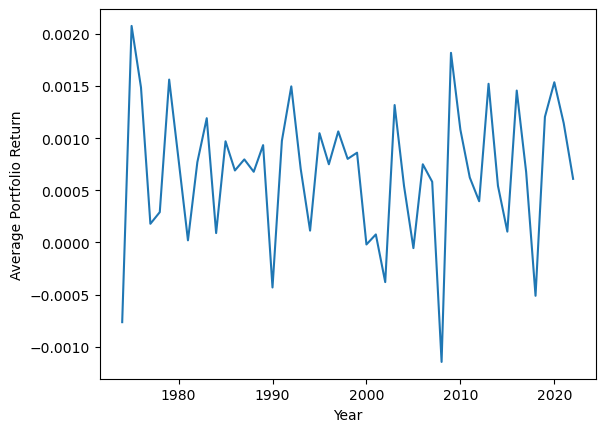

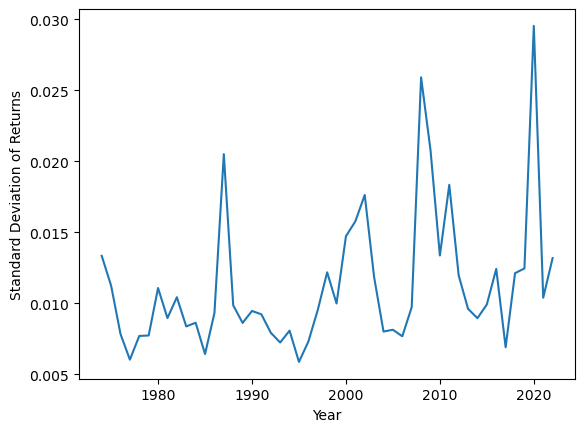

In [122]:
#Return stats on portfolio -- equal weighting
calc_portfolio_stats(capx_ppe_equal_portfolio).to_csv(outputFolder + 'capx_ppe_equal_output.csv', index=False)

Value Weighting

In [123]:
#Calculate portfolio weights -- value
capx_ppe_value_temp = daily_returns_filtered_capx_ppe.copy()
lastDate_capex_ppe = capx_ppe_value_temp.groupby(['year'])['date'].max().reset_index()
capx_ppe_port_last = pd.merge(left=lastDate_capex_ppe, right=capx_ppe_value_temp, on=['year','date'], how='left')
capx_ppe_value_weights = calc_portfolio_weights(capx_ppe_port_last, weight_type='value')
capx_ppe_value_weights = capx_ppe_value_weights.sort_values(by=['PERMNO', 'date'])
capx_ppe_value_weights['L_p_weight'] = capx_ppe_value_weights.groupby('PERMNO')['p_weight'].shift(1)
capx_ppe_value_weights = pd.merge(left=capx_ppe_value_temp, right=capx_ppe_value_weights[['year','PERMNO','p_weight','L_p_weight']], on=['year','PERMNO'], how='inner')
capx_ppe_value_weights['L_p_weight'] = capx_ppe_value_weights['L_p_weight'].fillna(0)

In [ ]:
#Lag portfolio weights to following year
#capx_ppe_value_weights_Lagged = capx_ppe_value_weights.sort_values(by=['PERMNO', 'date'])
#capx_ppe_value_weights_Lagged['L_p_weight'] = capx_ppe_value_weights_Lagged.groupby('PERMNO')['p_weight'].shift(252)

#If Lagged portfolio weight is NaN, fill with 0
#capx_ppe_value_weights_Lagged['L_p_weight'] = capx_ppe_value_weights_Lagged['L_p_weight'].fillna(0)

In [124]:
#Calculate portfolio returns -- value weighting
capx_ppe_value_portfolio = calc_portfolio_returns(capx_ppe_value_weights)

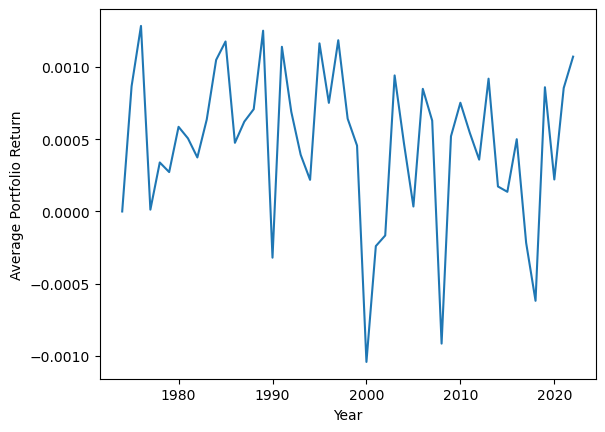

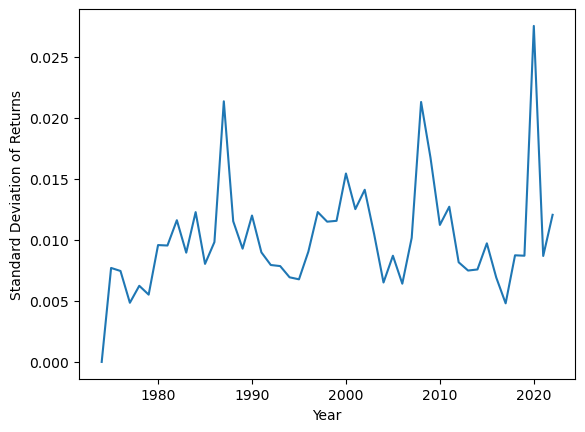

In [125]:
#Return stats on portfolio -- value weighting
calc_portfolio_stats(capx_ppe_value_portfolio).to_csv(outputFolder + 'capx_ppe_value_output.csv', index=False)

# Low EBIT/Pre-tax Income
EBIT (ebit) and Pre-tax Income (pi) from Compustat

In [139]:
#CSV download contains all columns in Compustat from 01/01/1974 to 12/30/2022. Bring in only subset of columns
ebit_pi_raw = pd.read_csv(outputFolder + 'daily_compustat_raw.zip',compression='zip',usecols=['gvkey','tic','fyear','ebit','pi'])

In [140]:
#Clean ebit_pi_raw data
ebit_pi_raw.dropna(subset=['fyear','ebit','pi'], inplace=True)
ebit_pi_raw['fyear']=pd.to_numeric(ebit_pi_raw['fyear'], errors='coerce', downcast='integer')
ebit_pi_raw['ebit']=pd.to_numeric(ebit_pi_raw['ebit'], errors='coerce')
ebit_pi_raw['pi']=pd.to_numeric(ebit_pi_raw['pi'], errors='coerce')

#Merge Linking data to get Permno
ebit_pi_raw = ebit_pi_raw.rename(columns={'gvkey':'GVKEY'})
ebit_pi = pd.merge(left=ebit_pi_raw, right=linkTable, on=['GVKEY'], how='left')

#Rename columns
ebit_pi = ebit_pi.rename(columns={'fyear':'year', 'LPERMNO':'PERMNO'})
ebit_pi.dropna(subset=['PERMNO'], inplace=True)
ebit_pi['PERMNO']=pd.to_numeric(ebit_pi['PERMNO'], errors='coerce', downcast='integer')

#Remove negatives
ebit_pi = ebit_pi[ebit_pi['ebit']>0]
ebit_pi = ebit_pi[ebit_pi['pi']>0]

In [141]:
#Create ebit_pi ratio column
ebit_pi['ebit_pi_ratio'] = ebit_pi['ebit']/ebit_pi['pi']

ebit_pi['ebit_pi_ratio_minus_one'] = abs(ebit_pi['ebit_pi_ratio']-1)

In [142]:
tempebitpi = dailyReturnsUniverse.groupby(['year', 'PERMNO']).first().reset_index()
tempebitpi = tempebitpi[['year','PERMNO']]
ratios_with_returns = pd.merge(left=tempebitpi, right=ebit_pi, on=['year','PERMNO'], how='left')

In [143]:
#Create a new rank column that ranks EBIT/PI every year. Lower value ranked higher
ratios_with_returns['ebit_pi_ratio_rank'] = ratios_with_returns.groupby(['year'])['ebit_pi_ratio_minus_one'].rank(ascending=True, method='first')

In [144]:
#Get top 20 ranked for every year
ebit_pi_rank = ratios_with_returns.groupby('year').apply(lambda x: x.nsmallest(20, 'ebit_pi_ratio_rank')).reset_index(drop=True)

In [111]:
#Export companies with signal to CSV
pd.merge(left=ebit_pi_rank, right=linkTable[['PERMNO','tic','conm']], on=['PERMNO'], how='left').to_csv(outputFolder + 'ebit_pi_rank.csv', index=False)

In [132]:
#Get daily returns of PERMNOs that show signal every year
daily_returns_filtered_ebit_pi = pd.merge(right=dailyReturnsUniverse, left=ebit_pi_rank[['PERMNO', 'year', 'ebit_pi_ratio_rank']], on=['year', 'PERMNO'], how='left')

In [124]:
count_nan(daily_returns_filtered_ebit_pi, ['RET'])

Number of rows in column: RET with NaN =  0


In [125]:
#Get PERMNO count per year
print(daily_returns_filtered_ebit_pi.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      16
1   1975      14
2   1976      15
3   1977      16
4   1978      14
5   1979      14
6   1980      14
7   1981      13
8   1982      15
9   1983      15
10  1984      14
11  1985      14
12  1986      13
13  1987      15
14  1988      14
15  1989      12
16  1990      13
17  1991      12
18  1992      16
19  1993      17
20  1994      18
21  1995      17
22  1996      18
23  1997      19
24  1998      15
25  1999      19
26  2000      17
27  2001      15
28  2002      17
29  2003      19
30  2004      18
31  2005      18
32  2006      18
33  2007      18
34  2008      16
35  2009      19
36  2010      18
37  2011      19
38  2012      20
39  2013      19
40  2014      18
41  2015      18
42  2016      20
43  2017      18
44  2018      19
45  2019      17
46  2020      19
47  2021      17
48  2022      19


Equal Weighting

In [133]:
#Calculate portfolio weights -- equal
ebit_pi_equal_temp = daily_returns_filtered_ebit_pi.copy()
ebit_pi_equal_weights = calc_portfolio_weights(ebit_pi_equal_temp, weight_type='equal')
ebit_pi_equal_weights = ebit_pi_equal_weights.rename(columns={'p_weight':'L_p_weight'})

In [ ]:
#Lag portfolio weights to following year
#ebit_pi_equal_weights_Lagged = ebit_pi_equal_weights.sort_values(by=['PERMNO', 'date'])
#ebit_pi_equal_weights_Lagged['L_p_weight'] = ebit_pi_equal_weights_Lagged.groupby('PERMNO')['p_weight'].shift(252)

#If Lagged portfolio weight is NaN, fill with 0
#ebit_pi_equal_weights_Lagged['L_p_weight'] = ebit_pi_equal_weights_Lagged['L_p_weight'].fillna(0)

In [134]:
#Calculate portfolio returns -- equal weighting
ebit_pi_equal_portfolio = calc_portfolio_returns(ebit_pi_equal_weights)

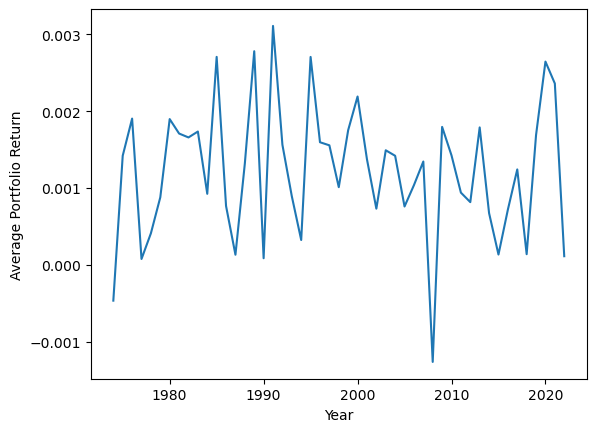

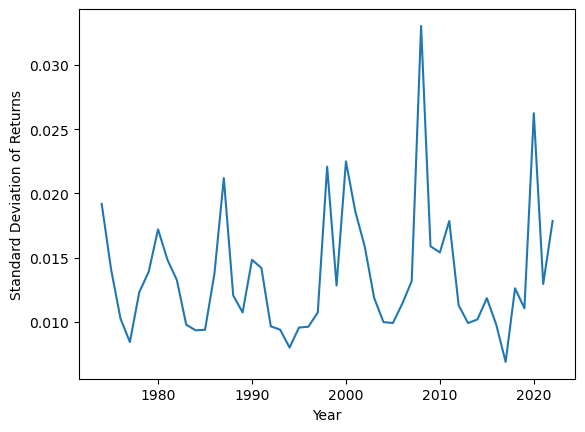

In [135]:
#Return stats on portfolio -- equal weighting
calc_portfolio_stats(ebit_pi_equal_portfolio).to_csv(outputFolder + 'ebit_pi_equal_output.csv', index=False)

Value Weighting

In [145]:
#Calculate portfolio weights -- value
ebit_pi_value_temp = daily_returns_filtered_ebit_pi.copy()
lastDate_ebit_pi = ebit_pi_value_temp.groupby(['year'])['date'].max().reset_index()
ebit_pi_port_last = pd.merge(left=lastDate_ebit_pi, right=ebit_pi_value_temp, on=['year','date'], how='left')
ebit_pi_value_weights = calc_portfolio_weights(ebit_pi_port_last, weight_type='value')
ebit_pi_value_weights = ebit_pi_value_weights.sort_values(by=['PERMNO', 'date'])
ebit_pi_value_weights['L_p_weight'] = ebit_pi_value_weights.groupby('PERMNO')['p_weight'].shift(1)
ebit_pi_value_weights = pd.merge(left=dailyReturnsUniverse, right=ebit_pi_value_weights[['year','PERMNO','p_weight','L_p_weight']], on=['year','PERMNO'], how='left')
ebit_pi_value_weights['L_p_weight'] = ebit_pi_value_weights['L_p_weight'].fillna(0)

In [ ]:
#Lag portfolio weights to following year
#ebit_pi_value_weights_Lagged = ebit_pi_value_weights.sort_values(by=['PERMNO', 'date'])
#ebit_pi_value_weights_Lagged['L_p_weight'] = ebit_pi_value_weights_Lagged.groupby('PERMNO')['p_weight'].shift(252)

#If Lagged portfolio weight is NaN, fill with 0
#ebit_pi_value_weights_Lagged['L_p_weight'] = ebit_pi_value_weights_Lagged['L_p_weight'].fillna(0)

In [146]:
#Calculate portfolio returns -- value weighting
ebit_pi_value_portfolio = calc_portfolio_returns(ebit_pi_value_weights)

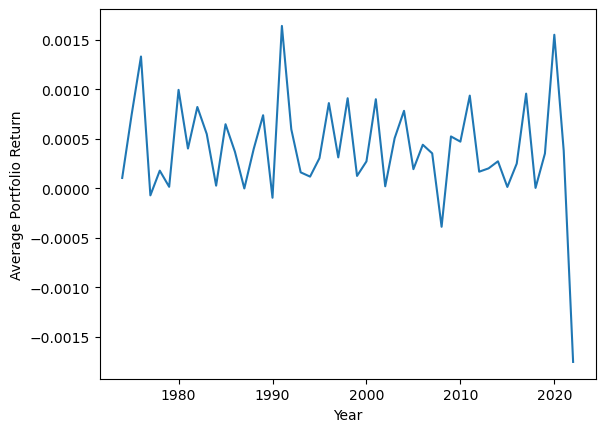

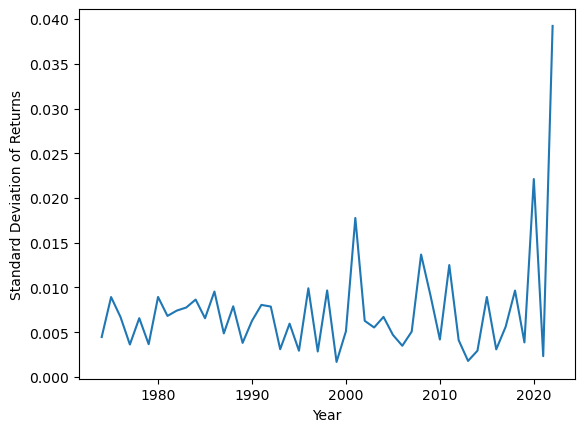

In [147]:
#Return stats on portfolio -- value weighting
calc_portfolio_stats(ebit_pi_value_portfolio).to_csv(outputFolder + 'ebit_pi_value_output.csv', index=False)

# Book/Market Ratio close to 1

In [14]:
#Read in financial ratios and clean data if necessary
fin_ratios = pd.read_pickle(outputFolder + 'fin_ratios.pkl')

In [15]:
tempbm = dailyReturnsUniverse.groupby(['year', 'PERMNO']).first().reset_index()
tempbm = tempbm[['year','PERMNO']]
ratios_with_returns = pd.merge(left=tempbm, right=fin_ratios, on=['year','PERMNO'], how='left')

In [16]:
ratios_with_returns['bm_minus_one'] = abs(ratios_with_returns['bm']-1)

#Create a new rank column that ranks BM-1 every year. Lower value ranked higher
ratios_with_returns['bm_minus_one_rank'] = ratios_with_returns.groupby(['year'])['bm_minus_one'].rank(ascending=True, method='first')

In [17]:
temp_bm = ratios_with_returns.copy()

In [152]:
#Get top 20 ranked for every year
bm_rank = ratios_with_returns.groupby('year').apply(lambda x: x.nsmallest(20, 'bm_minus_one_rank')).reset_index(drop=True)

In [126]:
#Export companies with signal to CSV
pd.merge(left=bm_rank, right=linkTable[['PERMNO','tic','conm']], on=['PERMNO'], how='left').to_csv(outputFolder + 'bm_rank.csv', index=False)

In [153]:
#Get daily returns of PERMNOs that show signal every year
daily_returns_filtered_bm = pd.merge(right=dailyReturnsUniverse, left=bm_rank[['PERMNO', 'year', 'bm_minus_one_rank']], on=['year', 'PERMNO'], how='left')

In [136]:
count_nan(daily_returns_filtered_bm, ['RET'])

Number of rows in column: RET with NaN =  0


In [137]:
#Get PERMNO count per year
print(daily_returns_filtered_bm.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      20
1   1975      20
2   1976      20
3   1977      20
4   1978      20
5   1979      20
6   1980      20
7   1981      20
8   1982      20
9   1983      20
10  1984      20
11  1985      20
12  1986      20
13  1987      20
14  1988      20
15  1989      20
16  1990      20
17  1991      20
18  1992      20
19  1993      20
20  1994      20
21  1995      20
22  1996      20
23  1997      20
24  1998      20
25  1999      20
26  2000      20
27  2001      20
28  2002      20
29  2003      20
30  2004      20
31  2005      20
32  2006      20
33  2007      20
34  2008      20
35  2009      20
36  2010      20
37  2011      20
38  2012      20
39  2013      20
40  2014      20
41  2015      20
42  2016      20
43  2017      20
44  2018      20
45  2019      20
46  2020      20
47  2021      20
48  2022      20


Equal Weighting

In [154]:
#Calculate portfolio weights -- equal
bm_equal_temp = daily_returns_filtered_bm.copy()
bm_equal_weights = calc_portfolio_weights(bm_equal_temp, weight_type='equal')
bm_equal_weights = bm_equal_weights.rename(columns={'p_weight':'L_p_weight'})

In [155]:
#Calculate portfolio returns -- equal weighting
bm_equal_portfolio = calc_portfolio_returns(bm_equal_weights)

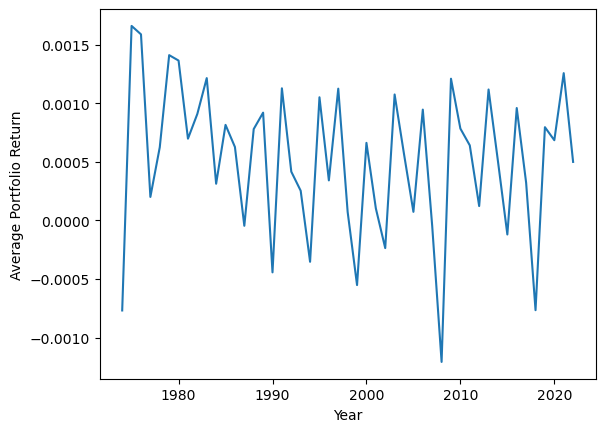

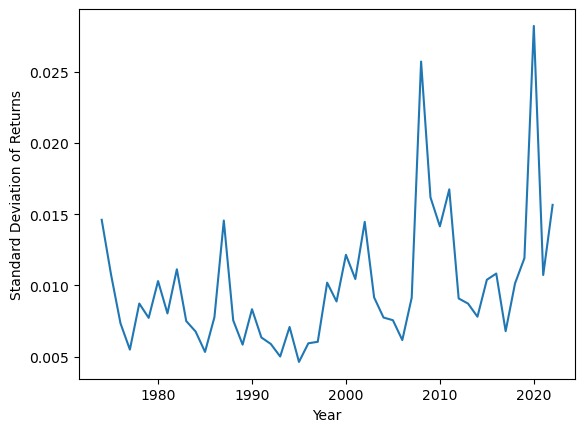

In [156]:
#Return stats on portfolio -- equal weighting
calc_portfolio_stats(bm_equal_portfolio).to_csv(outputFolder + 'bm_equal_output.csv', index=False)

Value Weighting

In [157]:
#Calculate portfolio weights -- value
bm_value_temp = daily_returns_filtered_bm.copy()
lastDate_bm = bm_value_temp.groupby(['year'])['date'].max().reset_index()
bm_port_last = pd.merge(left=lastDate_bm, right=bm_value_temp, on=['year','date'], how='left')
bm_value_weights = calc_portfolio_weights(bm_port_last, weight_type='value')
bm_value_weights = bm_value_weights.sort_values(by=['PERMNO', 'date'])
bm_value_weights['L_p_weight'] = bm_value_weights.groupby('PERMNO')['p_weight'].shift(1)
bm_value_weights = pd.merge(left=bm_value_temp, right=bm_value_weights[['year','PERMNO','p_weight','L_p_weight']], on=['year','PERMNO'], how='left')
bm_value_weights['L_p_weight'] = bm_value_weights['L_p_weight'].fillna(0)

In [158]:
#Calculate portfolio returns -- value weighting
bm_value_portfolio = calc_portfolio_returns(bm_value_weights)

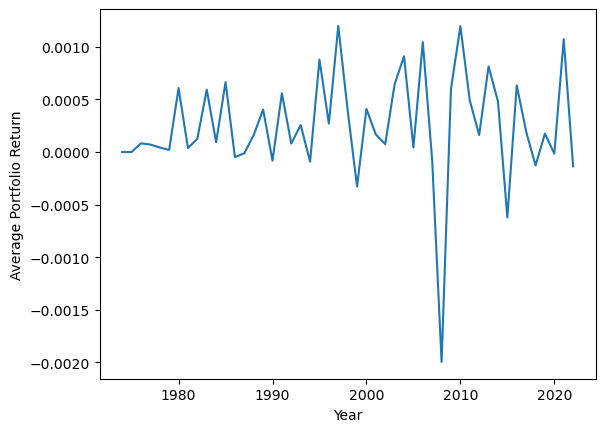

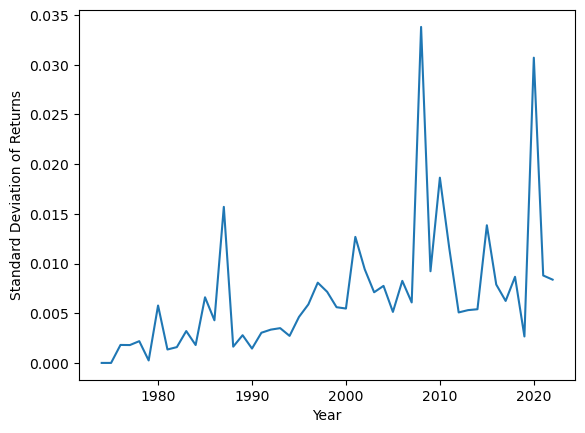

In [159]:
#Return stats on portfolio -- value weighting
calc_portfolio_stats(bm_value_portfolio).to_csv(outputFolder + 'bm_value_output.csv', index=False)

# Low Beta & Book-to-Market

In [37]:
#Merge ranked columns data
permno_signal = pd.merge(left=temp_bm[['PERMNO','year','bm_minus_one_rank']], right=betas_with_returns[['PERMNO','year','betas_rank']], on=['PERMNO','year'], how='inner')
permno_signal = permno_signal.dropna(subset=['bm_minus_one_rank', 'betas_rank'])

#Get top 20 ranked for every year
bm_rank = permno_signal.groupby('year').apply(lambda x: x.nsmallest(20, 'bm_minus_one_rank')).reset_index(drop=True)
beta_rank = permno_signal.groupby('year').apply(lambda x: x.nsmallest(20, 'betas_rank')).reset_index(drop=True)

#Combine to get top 20 in each rank
permno_signal_filtered = pd.concat([bm_rank, beta_rank], axis=0)
permno_signal_filtered = permno_signal_filtered.sort_values(by=['year', 'PERMNO']).reset_index()
permno_signal_filtered = permno_signal_filtered.drop_duplicates(subset=['year','PERMNO'], keep='first')

In [19]:
#Get PERMNO count per year
print(permno_signal_filtered.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      40
1   1975      39
2   1976      40
3   1977      40
4   1978      40
5   1979      39
6   1980      40
7   1981      37
8   1982      40
9   1983      39
10  1984      40
11  1985      39
12  1986      37
13  1987      40
14  1988      38
15  1989      39
16  1990      40
17  1991      39
18  1992      39
19  1993      40
20  1994      40
21  1995      37
22  1996      40
23  1997      37
24  1998      37
25  1999      36
26  2000      37
27  2001      38
28  2002      40
29  2003      39
30  2004      40
31  2005      40
32  2006      39
33  2007      39
34  2008      40
35  2009      39
36  2010      40
37  2011      40
38  2012      39
39  2013      40
40  2014      35
41  2015      35
42  2016      35
43  2017      37
44  2018      36
45  2019      40
46  2020      40
47  2021      38
48  2022      40


In [38]:
#Create weighted signal and get top 20
betas_bm = create_weighted_signal(permno_signal_filtered, ['betas_rank', 'bm_minus_one_rank'], [0.9, 0.1])

top_weighted_signal = betas_bm.groupby('year').apply(lambda x: x.nsmallest(20, 'weighted_signal')).reset_index(drop=True)

In [21]:
#Get PERMNO count per year
print(top_weighted_signal.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      20
1   1975      20
2   1976      20
3   1977      20
4   1978      20
5   1979      20
6   1980      20
7   1981      20
8   1982      20
9   1983      20
10  1984      20
11  1985      20
12  1986      20
13  1987      20
14  1988      20
15  1989      20
16  1990      20
17  1991      20
18  1992      20
19  1993      20
20  1994      20
21  1995      20
22  1996      20
23  1997      20
24  1998      20
25  1999      20
26  2000      20
27  2001      20
28  2002      20
29  2003      20
30  2004      20
31  2005      20
32  2006      20
33  2007      20
34  2008      20
35  2009      20
36  2010      20
37  2011      20
38  2012      20
39  2013      20
40  2014      20
41  2015      20
42  2016      20
43  2017      20
44  2018      20
45  2019      20
46  2020      20
47  2021      20
48  2022      20


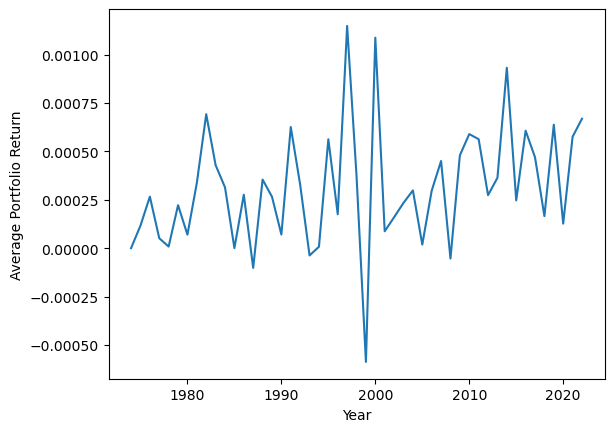

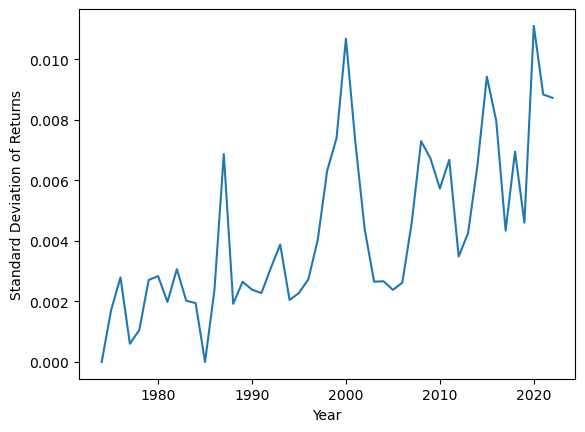

0.06829806081427618


In [39]:
#Merge returns and weights
df_Daily_Portfolio = pd.merge(left=dailyReturnsUniverse, right=top_weighted_signal[['PERMNO', 'year', 'weighted_signal']], on=['PERMNO', 'year'], how='inner')

lastDate = df_Daily_Portfolio.groupby(['year'])['date'].max().reset_index()
port_last = pd.merge(left=lastDate, right=df_Daily_Portfolio, on=['year','date'], how='left')
betas_bm_weights = calc_portfolio_weights(port_last, 'signal')
betas_bm_weights = betas_bm_weights.sort_values(by=['PERMNO', 'date'])
betas_bm_weights['L_p_weight'] = betas_bm_weights.groupby('PERMNO')['p_weight'].shift(1)

lastThreeYears = pd.merge(left=betas_bm_weights, right=linkTable[['PERMNO','tic','conm']], on=['PERMNO'], how='left')
lastThreeYears = lastThreeYears[(lastThreeYears['year']==2020) | (lastThreeYears['year']==2021) | (lastThreeYears['year']==2022)]
lastThreeYears.drop_duplicates(subset=['year','conm'], keep='first').to_csv('lastThreeYears.csv', index=False)

betas_bm_weights = pd.merge(left=dailyReturnsUniverse, right=betas_bm_weights[['year','PERMNO','p_weight','L_p_weight']], on=['year','PERMNO'], how='left')
betas_bm_weights = betas_bm_weights.sort_values(by=['PERMNO', 'year']).reset_index()
betas_bm_weights['L_p_weight'] = betas_bm_weights['L_p_weight'].fillna(0)

betas_bm_ret_value = calc_portfolio_returns(betas_bm_weights)

df_stats = calc_portfolio_stats(betas_bm_ret_value)
df_stats.to_csv(outputFolder + 'betas_bm_value.csv', index=False)
print(df_stats['ann_std'].mean())

In [259]:
test[test['year']==2011].to_csv('testsignal.csv', index=False)

# Low Beta & CapEx/PPE

In [318]:
#Merge ranked columns data
permno_signal = pd.merge(left=ratios_with_returns[['PERMNO','year','yoy_change_abs_rank']], right=betas_with_returns[['PERMNO','year','betas_rank']], on=['PERMNO','year'], how='inner')
permno_signal = permno_signal.dropna(subset=['yoy_change_abs_rank', 'betas_rank'])

#Get top 20 ranked for every year
capex_ppe_rank = permno_signal.groupby('year').apply(lambda x: x.nsmallest(20, 'yoy_change_abs_rank')).reset_index(drop=True)
beta_rank = permno_signal.groupby('year').apply(lambda x: x.nsmallest(20, 'betas_rank')).reset_index(drop=True)

#Combine to get top 20 in each rank
permno_signal_filtered = pd.concat([capex_ppe_rank, beta_rank], axis=0)
permno_signal_filtered = permno_signal_filtered.sort_values(by=['year', 'PERMNO']).reset_index()
permno_signal_filtered = permno_signal_filtered.drop_duplicates(subset=['year','PERMNO'], keep='first')

In [111]:
#Get PERMNO count per year
print(permno_signal_filtered.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      35
1   1975      34
2   1976      34
3   1977      35
4   1978      33
5   1979      34
6   1980      33
7   1981      34
8   1982      34
9   1983      33
10  1984      34
11  1985      31
12  1986      34
13  1987      34
14  1988      35
15  1989      35
16  1990      32
17  1991      33
18  1992      33
19  1993      33
20  1994      34
21  1995      31
22  1996      34
23  1997      31
24  1998      31
25  1999      32
26  2000      33
27  2001      33
28  2002      34
29  2003      36
30  2004      35
31  2005      32
32  2006      32
33  2007      38
34  2008      34
35  2009      37
36  2010      34
37  2011      28
38  2012      33
39  2013      32
40  2014      31
41  2015      34
42  2016      33
43  2017      32
44  2018      31
45  2019      33
46  2020      34
47  2021      35
48  2022      34


In [319]:
#Create weighted signal and get top 20
betas_capex_ppe = create_weighted_signal(permno_signal_filtered, ['betas_rank', 'yoy_change_abs_rank'], [0.9, 0.1])

top_weighted_signal = betas_capex_ppe.groupby('year').apply(lambda x: x.nsmallest(20, 'weighted_signal')).reset_index(drop=True)

In [113]:
#Get PERMNO count per year
print(top_weighted_signal.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      20
1   1975      20
2   1976      20
3   1977      20
4   1978      20
5   1979      20
6   1980      20
7   1981      20
8   1982      20
9   1983      20
10  1984      20
11  1985      20
12  1986      20
13  1987      20
14  1988      20
15  1989      20
16  1990      20
17  1991      20
18  1992      20
19  1993      20
20  1994      20
21  1995      20
22  1996      20
23  1997      20
24  1998      20
25  1999      20
26  2000      20
27  2001      20
28  2002      20
29  2003      20
30  2004      20
31  2005      20
32  2006      20
33  2007      20
34  2008      20
35  2009      20
36  2010      20
37  2011      20
38  2012      20
39  2013      20
40  2014      20
41  2015      20
42  2016      20
43  2017      20
44  2018      20
45  2019      20
46  2020      20
47  2021      20
48  2022      20


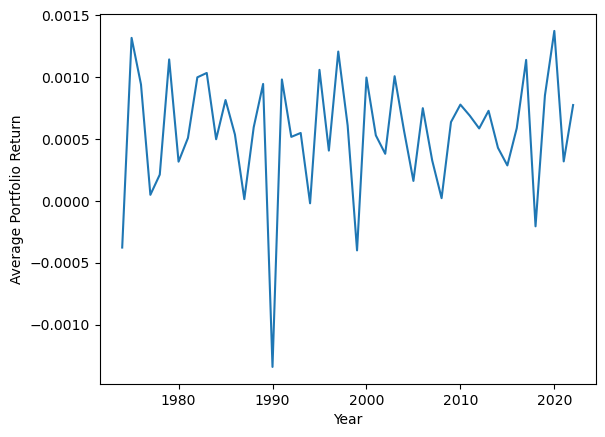

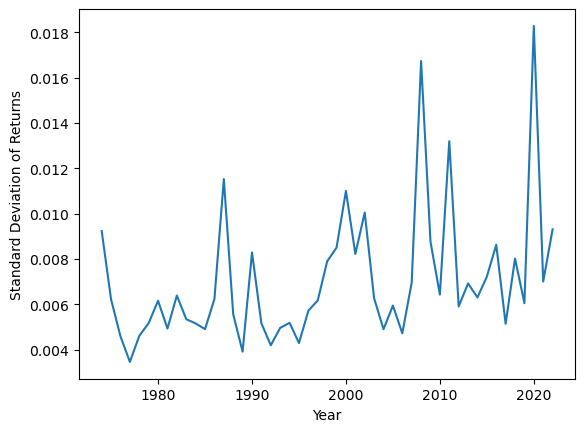

0.11202298265755371


In [320]:
#Merge returns and weights
df_Daily_Portfolio = pd.merge(left=dailyReturnsUniverse, right=top_weighted_signal[['PERMNO', 'year', 'weighted_signal']], on=['PERMNO', 'year'], how='inner')

lastDate = df_Daily_Portfolio.groupby(['year'])['date'].max().reset_index()
port_last = pd.merge(left=lastDate, right=df_Daily_Portfolio, on=['year','date'], how='left')
betas_capex_ppe_weights = calc_portfolio_weights(port_last, 'signal')
betas_capex_ppe_weights = pd.merge(left=df_Daily_Portfolio, right=betas_capex_ppe_weights[['year','PERMNO','p_weight']], on=['year','PERMNO'], how='left')

betas_capex_ppe_weights = betas_capex_ppe_weights.sort_values(by=['PERMNO', 'year']).reset_index()

betas_capex_ppe_ret_value = calc_portfolio_returns(betas_capex_ppe_weights)

df_stats = calc_portfolio_stats(betas_capex_ppe_ret_value)
df_stats.to_csv(outputFolder + 'betas_capex_ppe_value.csv', index=False)
print(df_stats['ann_std'].mean())

# Low Beta & ROE

In [303]:
#Merge ranked columns data
permno_signal = pd.merge(left=temp_roe[['PERMNO','year','roe_rank']], right=betas_with_returns[['PERMNO','year','betas_rank']], on=['PERMNO','year'], how='inner')
permno_signal = permno_signal.dropna(subset=['roe_rank', 'betas_rank'])

#Get top 20 ranked for every year
roe_rank = permno_signal.groupby('year').apply(lambda x: x.nsmallest(20, 'roe_rank')).reset_index(drop=True)
beta_rank = permno_signal.groupby('year').apply(lambda x: x.nsmallest(20, 'betas_rank')).reset_index(drop=True)

#Combine to get top 20 in each rank
permno_signal_filtered = pd.concat([roe_rank, beta_rank], axis=0)
permno_signal_filtered = permno_signal_filtered.sort_values(by=['year', 'PERMNO']).reset_index()
permno_signal_filtered = permno_signal_filtered.drop_duplicates(subset=['year','PERMNO'], keep='first')

In [126]:
#Get PERMNO count per year
print(permno_signal_filtered.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      39
1   1975      36
2   1976      40
3   1977      39
4   1978      40
5   1979      39
6   1980      40
7   1981      40
8   1982      40
9   1983      40
10  1984      40
11  1985      39
12  1986      38
13  1987      36
14  1988      39
15  1989      38
16  1990      39
17  1991      37
18  1992      38
19  1993      39
20  1994      36
21  1995      38
22  1996      37
23  1997      38
24  1998      35
25  1999      37
26  2000      37
27  2001      36
28  2002      36
29  2003      36
30  2004      35
31  2005      39
32  2006      36
33  2007      38
34  2008      38
35  2009      37
36  2010      35
37  2011      37
38  2012      36
39  2013      38
40  2014      37
41  2015      37
42  2016      36
43  2017      36
44  2018      37
45  2019      36
46  2020      34
47  2021      37
48  2022      38


In [304]:
#Create weighted signal and get top 20
betas_roe = create_weighted_signal(permno_signal_filtered, ['betas_rank', 'roe_rank'], [0.9, 0.1])

top_weighted_signal = betas_roe.groupby('year').apply(lambda x: x.nsmallest(20, 'weighted_signal')).reset_index(drop=True)

In [128]:
#Get PERMNO count per year
print(top_weighted_signal.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      20
1   1975      20
2   1976      20
3   1977      20
4   1978      20
5   1979      20
6   1980      20
7   1981      20
8   1982      20
9   1983      20
10  1984      20
11  1985      20
12  1986      20
13  1987      20
14  1988      20
15  1989      20
16  1990      20
17  1991      20
18  1992      20
19  1993      20
20  1994      20
21  1995      20
22  1996      20
23  1997      20
24  1998      20
25  1999      20
26  2000      20
27  2001      20
28  2002      20
29  2003      20
30  2004      20
31  2005      20
32  2006      20
33  2007      20
34  2008      20
35  2009      20
36  2010      20
37  2011      20
38  2012      20
39  2013      20
40  2014      20
41  2015      20
42  2016      20
43  2017      20
44  2018      20
45  2019      20
46  2020      20
47  2021      20
48  2022      20


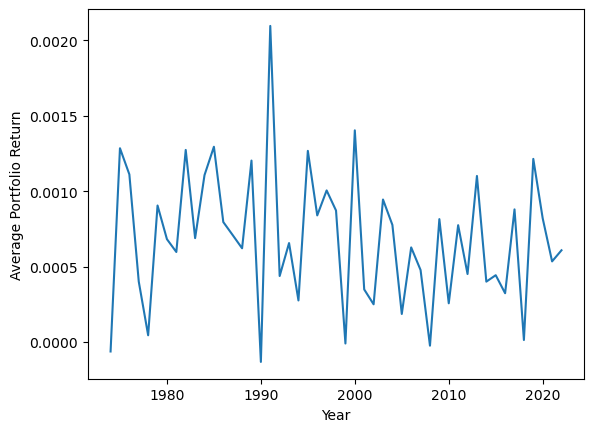

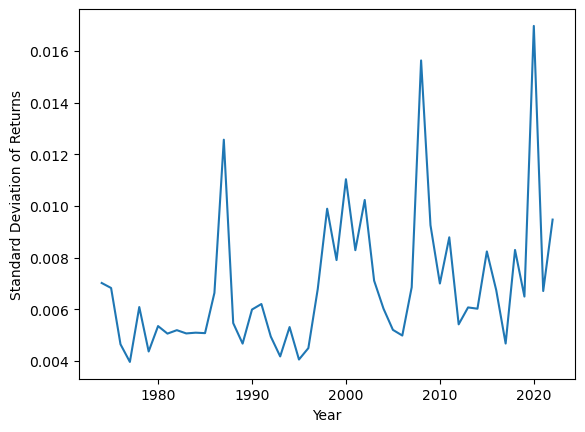

0.10953293676010555


In [305]:
#Merge returns and weights
df_Daily_Portfolio = pd.merge(left=dailyReturnsUniverse, right=top_weighted_signal[['PERMNO', 'year', 'weighted_signal']], on=['PERMNO', 'year'], how='inner')

lastDate = df_Daily_Portfolio.groupby(['year'])['date'].max().reset_index()
port_last = pd.merge(left=lastDate, right=df_Daily_Portfolio, on=['year','date'], how='left')
betas_roe_weights = calc_portfolio_weights(port_last, 'signal')
betas_roe_weights = pd.merge(left=df_Daily_Portfolio, right=betas_roe_weights[['year','PERMNO','p_weight']], on=['year','PERMNO'], how='left')

betas_roe_weights = betas_roe_weights.sort_values(by=['PERMNO', 'year']).reset_index()

betas_roe_ret_value = calc_portfolio_returns(betas_roe_weights)

df_stats = calc_portfolio_stats(betas_roe_ret_value)
df_stats.to_csv(outputFolder + 'betas_roe_value.csv', index=False)
print(df_stats['ann_std'].mean())

# CapEx/PPE & Book-to-Market

In [306]:
#Merge ranked columns data
permno_signal = pd.merge(left=ratios_with_returns[['PERMNO','year','yoy_change_abs_rank']], right=temp_bm[['PERMNO','year','bm_minus_one_rank']], on=['PERMNO','year'], how='inner')
permno_signal = permno_signal.dropna(subset=['yoy_change_abs_rank', 'bm_minus_one_rank'])

#Get top 20 ranked for every year
capex_ppe_rank = permno_signal.groupby('year').apply(lambda x: x.nsmallest(20, 'yoy_change_abs_rank')).reset_index(drop=True)
bm_rank = permno_signal.groupby('year').apply(lambda x: x.nsmallest(20, 'bm_minus_one_rank')).reset_index(drop=True)

#Combine to get top 20 in each rank
permno_signal_filtered = pd.concat([capex_ppe_rank, bm_rank], axis=0)
permno_signal_filtered = permno_signal_filtered.sort_values(by=['year', 'PERMNO']).reset_index()
permno_signal_filtered = permno_signal_filtered.drop_duplicates(subset=['year','PERMNO'], keep='first')

In [140]:
#Get PERMNO count per year
print(permno_signal_filtered.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      34
1   1975      35
2   1976      32
3   1977      33
4   1978      32
5   1979      32
6   1980      33
7   1981      32
8   1982      35
9   1983      32
10  1984      31
11  1985      32
12  1986      32
13  1987      32
14  1988      31
15  1989      34
16  1990      34
17  1991      30
18  1992      34
19  1993      31
20  1994      32
21  1995      32
22  1996      33
23  1997      31
24  1998      33
25  1999      33
26  2000      35
27  2001      30
28  2002      33
29  2003      30
30  2004      32
31  2005      33
32  2006      31
33  2007      34
34  2008      30
35  2009      33
36  2010      34
37  2011      34
38  2012      36
39  2013      36
40  2014      34
41  2015      30
42  2016      33
43  2017      35
44  2018      35
45  2019      36
46  2020      30
47  2021      36
48  2022      36


In [307]:
#Create weighted signal and get top 20
bm_capex_ppe = create_weighted_signal(permno_signal_filtered, ['bm_minus_one_rank', 'yoy_change_abs_rank'], [0.1, 0.9])

top_weighted_signal = bm_capex_ppe.groupby('year').apply(lambda x: x.nsmallest(20, 'weighted_signal')).reset_index(drop=True)

In [142]:
#Get PERMNO count per year
print(top_weighted_signal.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      20
1   1975      20
2   1976      20
3   1977      20
4   1978      20
5   1979      20
6   1980      20
7   1981      20
8   1982      20
9   1983      20
10  1984      20
11  1985      20
12  1986      20
13  1987      20
14  1988      20
15  1989      20
16  1990      20
17  1991      20
18  1992      20
19  1993      20
20  1994      20
21  1995      20
22  1996      20
23  1997      20
24  1998      20
25  1999      20
26  2000      20
27  2001      20
28  2002      20
29  2003      20
30  2004      20
31  2005      20
32  2006      20
33  2007      20
34  2008      20
35  2009      20
36  2010      20
37  2011      20
38  2012      20
39  2013      20
40  2014      20
41  2015      20
42  2016      20
43  2017      20
44  2018      20
45  2019      20
46  2020      20
47  2021      20
48  2022      20


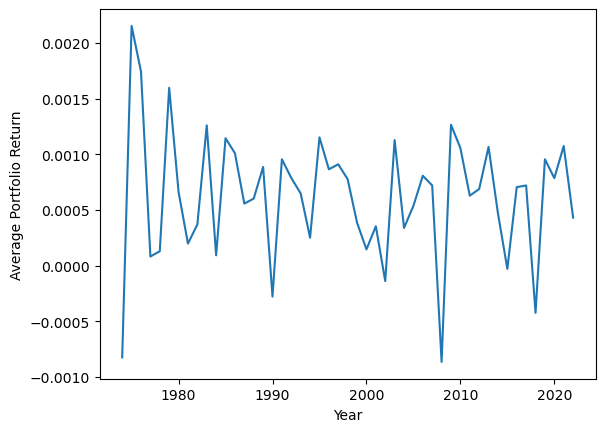

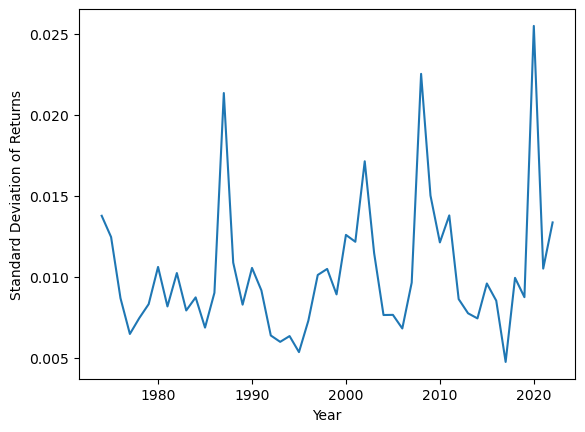

0.16297753853594069


In [308]:
#Merge returns and weights
df_Daily_Portfolio = pd.merge(left=dailyReturnsUniverse, right=top_weighted_signal[['PERMNO', 'year', 'weighted_signal']], on=['PERMNO', 'year'], how='inner')

lastDate = df_Daily_Portfolio.groupby(['year'])['date'].max().reset_index()
port_last = pd.merge(left=lastDate, right=df_Daily_Portfolio, on=['year','date'], how='left')
bm_capex_ppe_weights = calc_portfolio_weights(port_last, 'signal')
bm_capex_ppe_weights = pd.merge(left=df_Daily_Portfolio, right=bm_capex_ppe_weights[['year','PERMNO','p_weight']], on=['year','PERMNO'], how='left')

bm_capex_ppe_weights = bm_capex_ppe_weights.sort_values(by=['PERMNO', 'year']).reset_index()

bm_capex_ppe_ret_value = calc_portfolio_returns(bm_capex_ppe_weights)

df_stats = calc_portfolio_stats(bm_capex_ppe_ret_value)
df_stats.to_csv(outputFolder + 'bm_capex_ppe_value.csv', index=False)
print(df_stats['ann_std'].mean())

# CapEx/PPE & ROE

In [309]:
#Merge ranked columns data
permno_signal = pd.merge(left=ratios_with_returns[['PERMNO','year','yoy_change_abs_rank']], right=temp_roe[['PERMNO','year','roe_rank']], on=['PERMNO','year'], how='inner')
permno_signal = permno_signal.dropna(subset=['yoy_change_abs_rank', 'roe_rank'])

#Get top 20 ranked for every year
capex_ppe_rank = permno_signal.groupby('year').apply(lambda x: x.nsmallest(20, 'yoy_change_abs_rank')).reset_index(drop=True)
roe_rank = permno_signal.groupby('year').apply(lambda x: x.nsmallest(20, 'roe_rank')).reset_index(drop=True)

#Combine to get top 20 in each rank
permno_signal_filtered = pd.concat([capex_ppe_rank, roe_rank], axis=0)
permno_signal_filtered = permno_signal_filtered.sort_values(by=['year', 'PERMNO']).reset_index()
permno_signal_filtered = permno_signal_filtered.drop_duplicates(subset=['year','PERMNO'], keep='first')

In [161]:
#Get PERMNO count per year
print(permno_signal_filtered.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      36
1   1975      34
2   1976      38
3   1977      39
4   1978      37
5   1979      37
6   1980      33
7   1981      36
8   1982      37
9   1983      39
10  1984      35
11  1985      33
12  1986      38
13  1987      38
14  1988      37
15  1989      33
16  1990      30
17  1991      30
18  1992      30
19  1993      31
20  1994      31
21  1995      33
22  1996      33
23  1997      34
24  1998      32
25  1999      34
26  2000      32
27  2001      33
28  2002      32
29  2003      34
30  2004      35
31  2005      34
32  2006      35
33  2007      35
34  2008      38
35  2009      33
36  2010      31
37  2011      32
38  2012      28
39  2013      32
40  2014      31
41  2015      32
42  2016      32
43  2017      32
44  2018      31
45  2019      32
46  2020      29
47  2021      34
48  2022      36


In [310]:
#Create weighted signal and get top 20
roe_capex_ppe = create_weighted_signal(permno_signal_filtered, ['roe_rank', 'yoy_change_abs_rank'], [0.1, 0.9])

top_weighted_signal = roe_capex_ppe.groupby('year').apply(lambda x: x.nsmallest(20, 'weighted_signal')).reset_index(drop=True)

In [237]:
#Get PERMNO count per year
print(top_weighted_signal.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      20
1   1975      20
2   1976      20
3   1977      20
4   1978      20
5   1979      20
6   1980      20
7   1981      20
8   1982      20
9   1983      20
10  1984      20
11  1985      20
12  1986      20
13  1987      20
14  1988      20
15  1989      20
16  1990      20
17  1991      20
18  1992      20
19  1993      20
20  1994      20
21  1995      20
22  1996      20
23  1997      20
24  1998      20
25  1999      20
26  2000      20
27  2001      20
28  2002      20
29  2003      20
30  2004      20
31  2005      20
32  2006      20
33  2007      20
34  2008      20
35  2009      20
36  2010      20
37  2011      20
38  2012      20
39  2013      20
40  2014      20
41  2015      20
42  2016      20
43  2017      20
44  2018      20
45  2019      20
46  2020      20
47  2021      20
48  2022      20


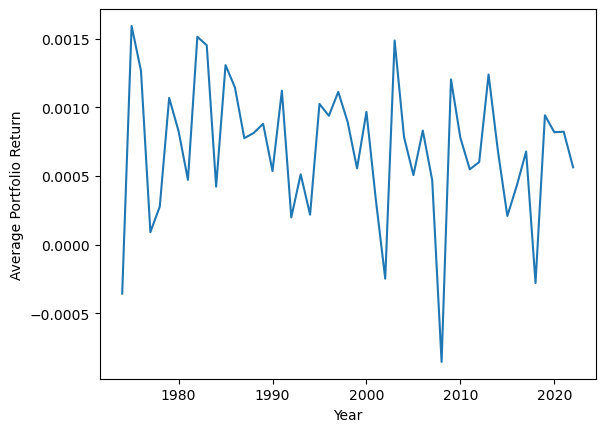

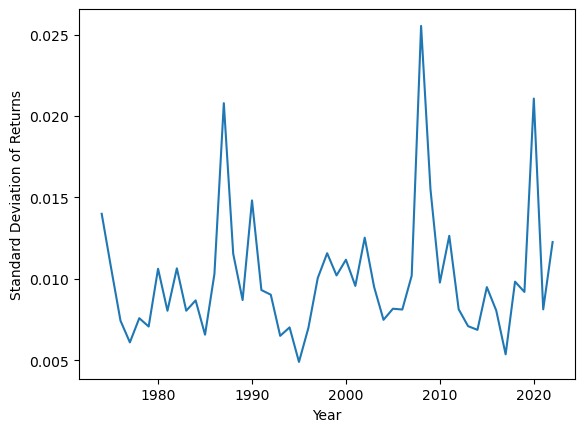

0.15959832650254033


In [311]:
#Merge returns and weights
df_Daily_Portfolio = pd.merge(left=dailyReturnsUniverse, right=top_weighted_signal[['PERMNO', 'year', 'weighted_signal']], on=['PERMNO', 'year'], how='inner')

lastDate = df_Daily_Portfolio.groupby(['year'])['date'].max().reset_index()
port_last = pd.merge(left=lastDate, right=df_Daily_Portfolio, on=['year','date'], how='left')
roe_capex_ppe_weights = calc_portfolio_weights(port_last, 'signal')
roe_capex_ppe_weights = pd.merge(left=df_Daily_Portfolio, right=roe_capex_ppe_weights[['year','PERMNO','p_weight']], on=['year','PERMNO'], how='left')

roe_capex_ppe_weights = roe_capex_ppe_weights.sort_values(by=['PERMNO', 'year']).reset_index()

roe_capex_ppe_ret_value = calc_portfolio_returns(roe_capex_ppe_weights)

df_stats = calc_portfolio_stats(roe_capex_ppe_ret_value)
df_stats.to_csv(outputFolder + 'roe_capex_ppe_value.csv', index=False)
print(df_stats['ann_std'].mean())

# Book-to-Market & ROE

In [312]:
#Merge ranked columns data
permno_signal = pd.merge(left=temp_bm[['PERMNO','year','bm_minus_one_rank']], right=temp_roe[['PERMNO','year','roe_rank']], on=['PERMNO','year'], how='inner')
permno_signal = permno_signal.dropna(subset=['bm_minus_one_rank', 'roe_rank'])

#Get top 20 ranked for every year
bm_rank = permno_signal.groupby('year').apply(lambda x: x.nsmallest(20, 'bm_minus_one_rank')).reset_index(drop=True)
roe_rank = permno_signal.groupby('year').apply(lambda x: x.nsmallest(20, 'roe_rank')).reset_index(drop=True)

#Combine to get top 20 in each rank
permno_signal_filtered = pd.concat([bm_rank, roe_rank], axis=0)
permno_signal_filtered = permno_signal_filtered.sort_values(by=['year', 'PERMNO']).reset_index()
permno_signal_filtered = permno_signal_filtered.drop_duplicates(subset=['year','PERMNO'], keep='first')

In [176]:
#Get PERMNO count per year
print(permno_signal_filtered.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      38
1   1975      38
2   1976      40
3   1977      40
4   1978      40
5   1979      40
6   1980      40
7   1981      40
8   1982      40
9   1983      40
10  1984      38
11  1985      40
12  1986      40
13  1987      39
14  1988      40
15  1989      40
16  1990      40
17  1991      38
18  1992      40
19  1993      39
20  1994      39
21  1995      39
22  1996      39
23  1997      40
24  1998      40
25  1999      40
26  2000      40
27  2001      40
28  2002      40
29  2003      40
30  2004      38
31  2005      38
32  2006      40
33  2007      40
34  2008      40
35  2009      40
36  2010      39
37  2011      39
38  2012      40
39  2013      40
40  2014      38
41  2015      39
42  2016      40
43  2017      40
44  2018      40
45  2019      40
46  2020      39
47  2021      40
48  2022      39


In [313]:
#Create weighted signal and get top 20
bm_roe = create_weighted_signal(permno_signal_filtered, ['bm_minus_one_rank', 'roe_rank'], [0.9, 0.1])

top_weighted_signal = bm_roe.groupby('year').apply(lambda x: x.nsmallest(20, 'weighted_signal')).reset_index(drop=True)

In [230]:
#Get PERMNO count per year
print(top_weighted_signal.groupby('year')['PERMNO'].nunique().reset_index())

    year  PERMNO
0   1974      20
1   1975      20
2   1976      20
3   1977      20
4   1978      20
5   1979      20
6   1980      20
7   1981      20
8   1982      20
9   1983      20
10  1984      20
11  1985      20
12  1986      20
13  1987      20
14  1988      20
15  1989      20
16  1990      20
17  1991      20
18  1992      20
19  1993      20
20  1994      20
21  1995      20
22  1996      20
23  1997      20
24  1998      20
25  1999      20
26  2000      20
27  2001      20
28  2002      20
29  2003      20
30  2004      20
31  2005      20
32  2006      20
33  2007      20
34  2008      20
35  2009      20
36  2010      20
37  2011      20
38  2012      20
39  2013      20
40  2014      20
41  2015      20
42  2016      20
43  2017      20
44  2018      20
45  2019      20
46  2020      20
47  2021      20
48  2022      20


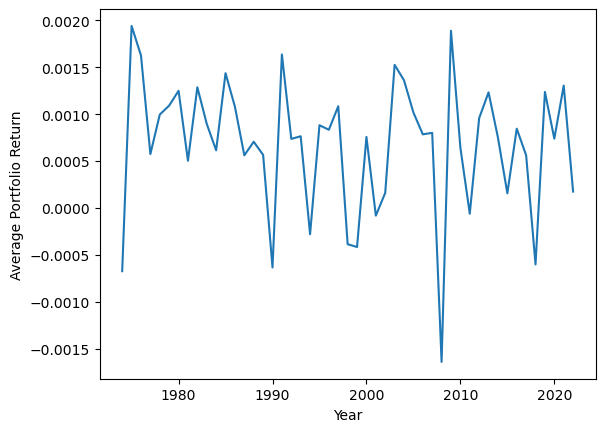

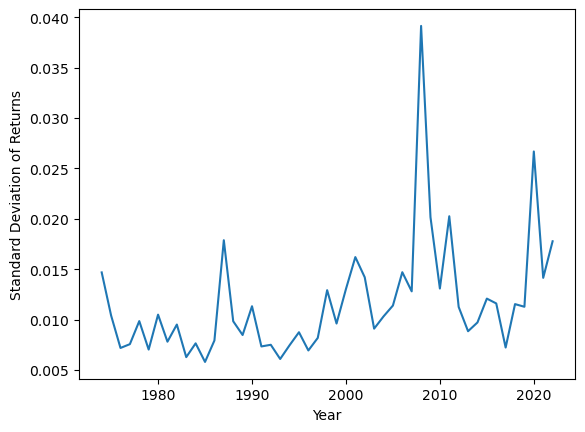

0.18503872412757807


In [314]:
#Merge returns and weights
df_Daily_Portfolio = pd.merge(left=dailyReturnsUniverse, right=top_weighted_signal[['PERMNO', 'year', 'weighted_signal']], on=['PERMNO', 'year'], how='inner')

lastDate = df_Daily_Portfolio.groupby(['year'])['date'].max().reset_index()
port_last = pd.merge(left=lastDate, right=df_Daily_Portfolio, on=['year','date'], how='left')
bm_roe_weights = calc_portfolio_weights(port_last, 'signal')
bm_roe_weights = pd.merge(left=df_Daily_Portfolio, right=bm_roe_weights[['year','PERMNO','p_weight']], on=['year','PERMNO'], how='left')

bm_roe_weights = bm_roe_weights.sort_values(by=['PERMNO', 'year']).reset_index()

bm_roe_ret_value = calc_portfolio_returns(bm_roe_weights)

df_stats = calc_portfolio_stats(bm_roe_ret_value)
df_stats.to_csv(outputFolder + 'bm_roe_ret_value.csv', index=False)
print(df_stats['ann_std'].mean())

In [382]:
#Define returns 
returns = pd.read_csv(outputFolder + 'last 20 yrs.csv')
returns['RET']=pd.to_numeric(returns['RET'], errors='coerce')
returns['date'] = pd.to_datetime(returns['date'], format='%Y-%m-%d')
returns['year']=returns['date'].dt.year
returns = returns[returns['year']==2018]
returns = returns.dropna()
pivoted_df = returns.pivot(index=None, columns='PERMNO', values='RET')
#returns_arr = pivoted_df.values
#returns_arr
pivoted_df

PERMNO,11404,14401,15720,17144,18163,18729,22752,23026,23393,24766,...,26825,27991,32870,39642,42585,52090,56274,88924,89155,90444
3776,-0.016127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3777,-0.009452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3778,-0.011716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3779,-0.000978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3780,0.014069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.023712
101465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038940
101466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013524
101467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004194


# Portfolio Weighting
Given following 20 stocks, find optimal weighting. 
GIS, SJM, CPB, ED, HRL, OGS, MRK, CAG, PG, BDX, FLO, K, MKC, PNW, ORA, FE, EIX, CHD, NOC, CL

In [153]:
 def calc_final_portfolio_stats(df):
    #Calculate average rate of return and plot
    avg_return = df.groupby('year')['p_ret'].mean().reset_index(name='Avg Return')
    df.groupby('year')['p_ret'].mean().plot()
    plt.xlabel('Year')
    plt.ylabel('Average Portfolio Return')
    plt.show()
    
    #Calculate compound rate of return
    df[['p_ret_plus_one']] = df[['p_ret']]+1
    df['cumprod'] = df.groupby(['year'])['p_ret_plus_one'].cumprod()-1
    df_last_date = df.groupby(['year'])['date'].last().reset_index()
    df_compound = pd.merge(left=df_last_date, right=df, on=['year', 'date'], how='left')
    df_compound = df_compound.rename(columns={'cumprod':'Compound Return'})
    
    #Calculate standard deviation of portfolio returns
    std_returns = df.groupby('year')['p_ret'].std().reset_index(name='Std Dev')
    df.groupby('year')['p_ret'].std().plot()
    plt.xlabel('Year')
    plt.ylabel('Standard Deviation of Returns')
    plt.show()
    
    #Put everything in one df
    df_new = pd.merge(df_compound, avg_return, on='year', how='left')
    df_new = df_new.merge(std_returns, on='year')
    df_new['ann_std'] = df_new['Std Dev']*math.sqrt(252)
    
    return df_new



In [5]:
#Get data from 12/01/1974 to 11/30/2023

import yfinance as yf

#Prep data
stock_symbols = ["GIS", "SJM", "CPB", "ED", "HRL", "OGS", "MRK", "CAG", "PG", "BDX",
                 "FLO", "K", "MKC", "PNW", "ORA", "FE", "EIX", "CHD", "NOC", "CL"]

stock_permnos = [17144, 42585, 25320, 11404, 32870, 14401, 22752, 56274, 18163, 39642, 88924, 26825, 52090, 27991, 90444, 23026, 15720, 23393, 24766, 18729]

stock_link = pd.DataFrame({'tic': stock_symbols, 'PERMNO': stock_permnos})

#Download historical data
data = yf.download(stock_symbols, start="2023-01-01", end="2023-11-30")

#Calculate daily returns
returns = data['Adj Close'].pct_change()

returns = returns.reset_index()

melted_returns = pd.melt(returns, id_vars=['Date'], var_name='tic', value_name='RET')
melted_returns = melted_returns.rename(columns={'Date':'date'})

yf_returns = pd.merge(left=melted_returns, right=stock_link, on=['tic'], how='left')

yf_returns = yf_returns.dropna(subset=['RET'])




[*********************100%***********************]  20 of 20 completed


In [6]:
#List of PERMNO values to filter
permno_values_to_filter = [17144, 42585, 25320, 11404, 32870, 14401, 22752, 56274, 18163, 
                           39642, 88924, 26825, 52090, 27991, 90444, 23026, 15720, 23393, 
                           24766, 18729]

#Filter the df
filtered_port_returns = dailyReturnsUniverse[dailyReturnsUniverse['PERMNO'].isin(permno_values_to_filter)].reset_index(drop=True)



In [7]:
full_port_returns = pd.concat([filtered_port_returns[['PERMNO','date','RET','marketCap']], yf_returns[['PERMNO','date','RET']]], axis=0)
full_port_returns['year'] = full_port_returns['date'].dt.year

Solver for Weights

In [14]:
full_port_returns = full_port_returns[full_port_returns['date']>='1974-12-01'].reset_index(drop=True)

In [15]:
Last_Five_Ret = full_port_returns[full_port_returns['year']>=2016]
pivoted_df = Last_Five_Ret.pivot_table(index='date', columns='PERMNO', values='RET', aggfunc='mean')
returns_arr = pivoted_df.values
returns_arr

array([[ 0.002023  , -0.027307  , -0.004391  , ..., -0.014706  ,
         0.        , -0.036194  ],
       [ 0.007919  ,  0.001434  ,  0.000339  , ...,  0.000722  ,
         0.005584  ,  0.002276  ],
       [ 0.004776  ,  0.010436  , -0.006614  , ...,  0.005292  ,
        -0.011106  ,  0.011354  ],
       ...,
       [-0.00318822, -0.00355997,  0.0063781 , ..., -0.01052998,
        -0.01028035, -0.01429642],
       [ 0.00143382,  0.00408305,  0.00331977, ...,  0.00106416,
        -0.0084986 ,  0.02778625],
       [-0.00947137, -0.00254154, -0.01067828, ..., -0.00708713,
        -0.00999996,  0.00980398]])

In [13]:
pivoted_df.to_csv('pivoted_df.csv', index=True)

In [16]:
#Calculate covariance matrix
cov_matrix = np.cov(returns_arr, rowvar=False)

weights = cp.Variable(20)
weights_vector = cp.reshape(weights, (20, 1))

#Minimize portfolio variance
portfolio_variance = cp.quad_form(weights_vector, cov_matrix)
objective = cp.Minimize(portfolio_variance)

#Weights must sum to 1
constraints = [cp.sum(weights) == 1, weights >= 0]

problem = cp.Problem(objective, constraints)
problem.solve()

#Get optimal weights
optimal_weights = weights.value

print("Optimal Weights:")
print(optimal_weights)

optimal_portfolio_variance = portfolio_variance.value
print("Optimal Portfolio Variance:", optimal_portfolio_variance)

Optimal Weights:
[ 6.31641130e-02  9.53159149e-20  3.50141811e-03 -2.13326495e-18
  9.18594886e-02  7.59670001e-02  1.74715845e-01 -7.34163254e-19
  3.54880827e-02  8.30164532e-02  3.53520007e-02  4.95646986e-02
  1.16917034e-02  8.60763362e-02  1.14523574e-01  6.59548820e-02
 -4.60646791e-19  2.45100422e-02  3.17562637e-02  5.28580982e-02]
Optimal Portfolio Variance: [[8.56861974e-05]]


In [54]:
pd.DataFrame({'PERMNO': permno_values_to_filter, 'tic': stock_symbols,'weight': optimal_weights}).to_csv('final_weights.csv')

In [17]:
optimal_weights

array([ 6.31641130e-02,  9.53159149e-20,  3.50141811e-03, -2.13326495e-18,
        9.18594886e-02,  7.59670001e-02,  1.74715845e-01, -7.34163254e-19,
        3.54880827e-02,  8.30164532e-02,  3.53520007e-02,  4.95646986e-02,
        1.16917034e-02,  8.60763362e-02,  1.14523574e-01,  6.59548820e-02,
       -4.60646791e-19,  2.45100422e-02,  3.17562637e-02,  5.28580982e-02])

Equal Weighting

In [165]:
full_port_returns = pd.concat([filtered_port_returns[['PERMNO','date','RET','marketCap']], yf_returns[['PERMNO','date','RET']]], axis=0)
full_port_returns['year'] = full_port_returns['date'].dt.year
full_port_returns['month'] = full_port_returns['date'].dt.month
full_port_filtered = full_port_returns[full_port_returns['year']<2023]
full_port_filtered = full_port_filtered[full_port_filtered['month']==12]
full_port_filtered = full_port_filtered[full_port_filtered['date']>='1974-12-01'].reset_index(drop=True)

In [166]:
firstDate_full_port = full_port_filtered.groupby(['PERMNO','year'])['date'].first().reset_index()
firstDate_full_port['year'] = firstDate_full_port['date'].dt.year
firstDate_full_port = pd.merge(left=firstDate_full_port[['PERMNO','year','date']], right=full_port_filtered[['PERMNO','year','date','marketCap']], on=['PERMNO','year','date'], how='left')
equal_weight = calc_portfolio_weights(firstDate_full_port, 'equal')
equal_weight['month'] = equal_weight['date'].dt.month
equal_weight.to_csv('equal_w_full.csv', index=False)

In [167]:
#Create a DataFrame with month and year columns from 1974 to 2023
years = list(range(1974, 2024))
months = list(range(1, 13))

#Generate all combinations of year and month
date_combinations = [(year, month) for year in years for month in months]

#Create a DataFrame
months_yrs = pd.DataFrame(date_combinations, columns=['year', 'month'])

temp = pd.merge(left=months_yrs, right=equal_weight, on=['year','month'], how='left')
temp = temp.sort_values(by = ['year','month']).reset_index(drop=True)

# Create a mask for December
december_mask = temp['month'] == 12

# Duplicate the rows with month 12 to the following 11 months
df_extended = temp[december_mask].copy()
df_extended = pd.concat([df_extended] * 11, ignore_index=True)
df_extended['year'] = df_extended['year']+1
df_extended['month'] = df_extended.groupby(['PERMNO', 'year']).cumcount() + 1

#Combine the extended DataFrame with the original DataFrame
df_result = pd.concat([temp, df_extended], ignore_index=True, sort=False)

#Sort the resulting DataFrame by 'year' and 'month'
df_result.sort_values(by=['year', 'month'], inplace=True)

#Reset the index
df_result.reset_index(drop=True, inplace=True)

df_result = df_result.dropna(subset=['PERMNO'])

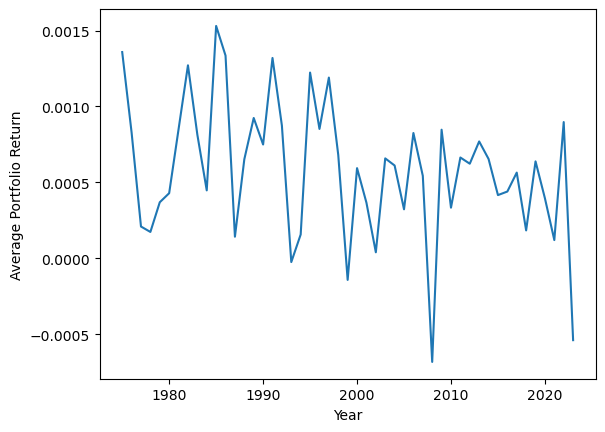

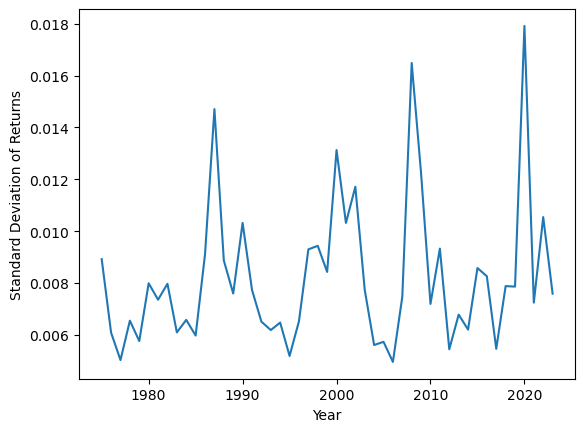

In [168]:
equal_weight_daily = pd.merge(left=full_port_returns[full_port_returns['date']>='1974-12-01'], right=df_result[['PERMNO','p_weight','year','month']], on=['year', 'month','PERMNO'], how='left')
equal_weight_daily.to_csv('equal_weight_daily.csv', index=False)
equal_weight_daily = equal_weight_daily.rename(columns={'p_weight':'L_p_weight'})

equal_returns = calc_portfolio_returns(equal_weight_daily)
equal_returns['year'] = equal_returns['date'].dt.year
equal_returns['month'] = equal_returns['date'].dt.month
equal_returns.loc[equal_returns['month'] == 12, 'year'] += 1
calc_final_portfolio_stats(equal_returns).to_csv('final_port_equal.csv', index=False)

Value Weighting

In [172]:
full_port_returns = pd.concat([filtered_port_returns[['PERMNO','date','RET','marketCap']], yf_returns[['PERMNO','date','RET']]], axis=0)
full_port_returns['year'] = full_port_returns['date'].dt.year
full_port_returns['month'] = full_port_returns['date'].dt.month
full_port_filtered = full_port_returns[full_port_returns['year']<2023]
full_port_filtered = full_port_filtered[full_port_filtered['month']==12]
full_port_filtered = full_port_filtered[full_port_filtered['date']>='1974-12-01'].reset_index(drop=True)

In [173]:
firstDate_full_port = full_port_filtered.groupby(['PERMNO','year'])['date'].first().reset_index()
firstDate_full_port['year'] = firstDate_full_port['date'].dt.year
firstDate_full_port = pd.merge(left=firstDate_full_port[['PERMNO','year','date']], right=full_port_filtered[['PERMNO','year','date','marketCap']], on=['PERMNO','year','date'], how='left')
value_weight = calc_portfolio_weights(firstDate_full_port, 'value')
value_weight['month'] = value_weight['date'].dt.month

In [174]:
#Create a DataFrame with month and year columns from 1974 to 2023
years = list(range(1974, 2024))
months = list(range(1, 13))

#Generate all combinations of year and month
date_combinations = [(year, month) for year in years for month in months]

#Create a DataFrame
months_yrs = pd.DataFrame(date_combinations, columns=['year', 'month'])

temp = pd.merge(left=months_yrs, right=value_weight, on=['year','month'], how='left')
temp = temp.sort_values(by = ['year','month']).reset_index(drop=True)

# Create a mask for December
december_mask = temp['month'] == 12

# Duplicate the rows with month 12 to the following 11 months
df_extended = temp[december_mask].copy()
df_extended = pd.concat([df_extended] * 11, ignore_index=True)
df_extended['year'] = df_extended['year']+1
df_extended['month'] = df_extended.groupby(['PERMNO', 'year']).cumcount() + 1

#Combine the extended DataFrame with the original DataFrame
df_result = pd.concat([temp, df_extended], ignore_index=True, sort=False)

#Sort the resulting DataFrame by 'year' and 'month'
df_result.sort_values(by=['year', 'month'], inplace=True)

#Reset the index
df_result.reset_index(drop=True, inplace=True)

df_result = df_result.dropna(subset=['PERMNO'])

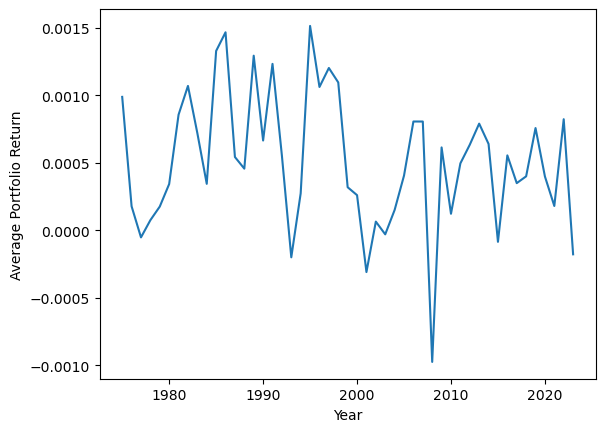

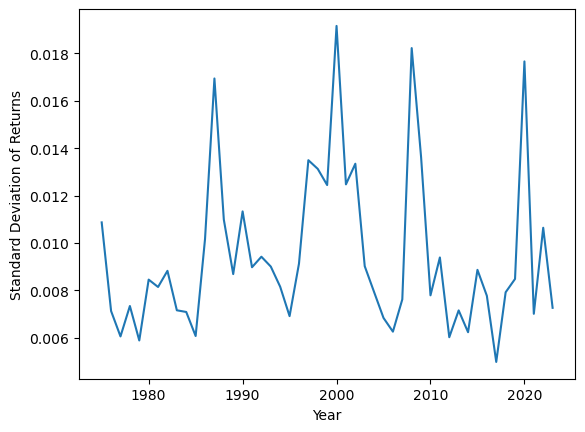

In [175]:
value_weight_daily = pd.merge(left=full_port_returns[full_port_returns['date']>='1974-12-01'], right=df_result[['PERMNO','p_weight','year','month']], on=['year', 'month','PERMNO'], how='left')

value_weight_daily = value_weight_daily.rename(columns={'p_weight':'L_p_weight'})

value_returns = calc_portfolio_returns(value_weight_daily)
value_returns['year'] = value_returns['date'].dt.year
value_returns['month'] = value_returns['date'].dt.month
value_returns.loc[value_returns['month'] == 12, 'year'] += 1
calc_final_portfolio_stats(value_returns).to_csv('final_port_value.csv', index=False)